# Sticky information and consumption response

## Preliminary

In [1]:
# imports

# %load_ext autoreload
# %autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy
from scipy.optimize import newton
from consav.markov import log_rouwenhorst
from tabulate import tabulate

mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.which'] = 'major'
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['grid.alpha'] = 0.2
plt.rc('font', size=16)

# from HANKStickyModel import HANKStickyModelClass
from HA_simple import HAsimpleModel

# Overview
Analysis about the interaction of sticky information and the consumption response:

1. Comparison to estimates from Fagereng et al. (2021)
2. Sluggishness in the consumption response to transfers
3. Decomposition of the consumption response
4. Dependence on persistence
5. Sensitvity to theta
6. iMPCs
7. Results for interest rate changes
8. Dependence on MPC targets
9. Dependence on sigma_e

In [2]:
model = HAsimpleModel.HAsimpleModelClass(par={'beta_mean': 0.9923, 'sigma_e': 0.36})
model.find_ss()
model._compute_jac_hh()
print(f'beta: {model.par.beta_mean}')
print(f'annualized beta: {model.par.beta_mean**4}')

beta: 0.9965534765214114
annualized beta: 0.9862850136128268


In [3]:
ss = model.ss
par = model.par

# Comparison to estimates from Fagereng et al. (2021)
iMPCs play an important role in the transmission of fiscal policy. The sticky information hereby affects the iMPCs to future income shocks, but leave the response to a shock in period 0 unaffected.
Here, I will show how the model matches the data by Fagereng et al. (2021) that provide (probably the most credible) estimates about MPCs to an unexpected income shock.

Note that their estimates are yearly, while my model is in quarterly frequency. For the first graph, I will compare the annual estimates to my annual iMPC. Specifically to
$$ \sum_{i=t}^{t+3} \frac{\partial C_i}{\partial y_0} (\frac{1}{1+r^{ss}})^{i}, t\in{0,1,2,3,4,5} $$

In [4]:
MPCs_data = [0.525, 0.175, 0.10, 0.045, 0.03, 0.025]
MPCs_model = [
    np.sum([model.jac_hh[('C_hh', 'y')][(t*4 + i), 0] / (1 + ss.r) ** (t*4 + i) for i in range(4)])
    for t in [0,1,2,3,4,5]
]
MPCs_model_ey = [
    np.sum([model.jac_hh[('C_hh', 'ey')][(t*4 + i), 0] / (1 + ss.r) ** (t*4 + i) for i in range(4)])
    for t in [0,1,2,3,4,5]
]

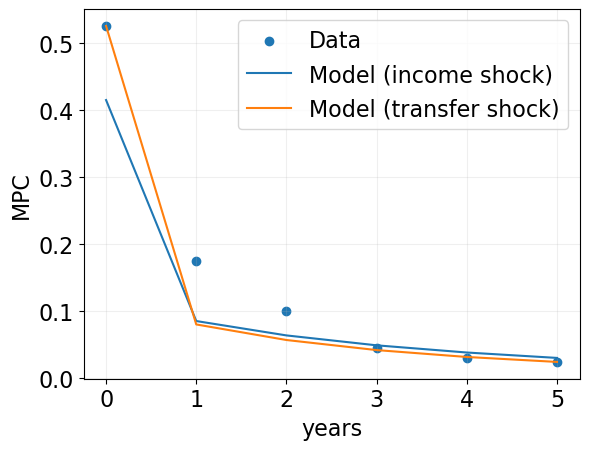

In [5]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(np.arange(6), MPCs_data, label='Data')
ax.plot(np.arange(6), MPCs_model, label='Model (income shock)')
ax.plot(np.arange(6), MPCs_model_ey, label='Model (transfer shock)')
ax.set_ylabel("MPC")
ax.set_xlabel('years')
ax.legend()

As Fagereng et al. (2021) note, these estimates consist of time-averaged responses. "For example, the within-year response is an average across households who won 0 to 12 months ago, the year 1 response is an average across households who won 0 to 24 months ago, and the year 2 response is an average across households who won 12 to 36 months ago."
In order to allow a mapping to models, they  provide an approximation based on the power form
$$ mpc(t) = \theta_1 t^{\theta_2} $$ with $[\theta_1, \theta_2] = [0.629, 0.214]$. The quarterly MPC is then defined as
$$\theta_1 (t/4)^{\theta_2}$$.
This formulation allows to compare their estimates to the quarterly model formulation. Note, that this leads to an implicit assumption that each household experiences the income increase at the beginning of each quarter.
-> not really realistic?

# Consumption response

In [6]:
model_sticky = model.copy()
model_sticky.par.inattention = 0.935

model.par.inattention = model_sticky.par.inattention
model_sticky.jac_hh= model._compute_sticky_jacs_hh(model.jac_hh)
model.par.inattention = 0.0

In [7]:
def plot_PE_hh(model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, title_list=None):

    nrows = len(compare_outputs)
    ncols = len(compare_inputs)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows), dpi=100)

    fig = plotter_PE(fig, model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, title_list=title_list)

    return fig

def plotter_PE(fig, model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump=0.01, shocks_rho=0.95, shock_series=None, linestyle='-', decompose=False, title_list=None):

    fig_i = 0

    use_custom_series = True if isinstance(shock_series, np.ndarray) else False

    if title_list == None:
        title_list = compare_inputs

    for output in compare_outputs:
        for i_s, shock in enumerate(compare_inputs):

            T = np.array([m.par.T for m in model_list]).min()
            if not use_custom_series:
                shock_series =  shocks_jump[i_s]*shocks_rho[i_s]**np.arange(T)

            ax = fig.axes[fig_i]
            fig_i += 1
            ax.set_title(f'Shock to {title_list[i_s]}')
            # ax.set_title(f'{shock}_shock on {output} (in %)')
            ax.set_xlabel('Quarters')
            y_label = output.split('_')[0]
            ax.set_ylabel(f'$\Delta {y_label}_t$ (in % from s.s.)')

            for i_m, m in enumerate(model_list):
                jac = m.jac_hh[(output, shock)].copy()
                ss_value = m.ss.__dict__[output]
                IRF_abs = jac @ shock_series
                IRF_perc = (IRF_abs / ss_value) * 100
                # plot
                ax.plot(np.arange(plot_periods), IRF_perc[:plot_periods], label=label_list[i_m], linestyle=linestyle)
                if decompose:
                    decompose_PE(ax, m, (output, shock), shock_series, ss_value, plot_periods)
            ax.legend()
            ax.set_xlim([0,plot_periods-1])

    return fig

def decompose_PE(ax, model, output_input, shock_series, ss_value, plot_periods):

    jac = model.jac_hh[output_input]

    # get hh jacs for theta = 1
    model_full_sticky = model.copy()
    if model.par.inattention > 0.0:
        model_full_sticky = model.copy()
        model_full_sticky.par.inattention = 0.0
        model_full_sticky._compute_jac_hh()
    model_full_sticky.par.inattention = 1.0
    jac_full_sticky = model_full_sticky._compute_sticky_jacs_hh(model_full_sticky.jac_hh)
    jac_full_sticky = jac_full_sticky[output_input]

    # Direct impact effect of shock
        # All elements except the diagonal to zero.
    jac_direct = np.diag(np.diag(jac_full_sticky))

    # Ex-post distributional effects
        # Elements on and above diagonal to zero.
    jac_post = jac_full_sticky.copy()
    for t in range(jac_post.shape[0]):
        jac_post[t,t] = 0.0

    # Anticipation effects
    jac_anticipation = jac - jac_direct - jac_post

    IRF = jac @ shock_series
    IRF_direct = jac_direct @ shock_series
    IRF_expost = jac_post @ shock_series
    IRF_anticip = jac_anticipation @ shock_series

    assert np.isclose(IRF - (IRF_direct + IRF_anticip + IRF_expost), 0.0).all()

    ax.plot(np.arange(plot_periods), (IRF_direct[:plot_periods] / ss_value)*100, label=f"impact", linestyle="--")

    ax.plot(np.arange(plot_periods), (IRF_anticip[:plot_periods] / ss_value)*100, label=f"anticipation", linestyle="--")

    ax.plot(np.arange(plot_periods), (IRF_expost[:plot_periods] / ss_value)*100, label=f"ex-post", linestyle="--")

    ax.set_xlim([0,plot_periods-1])

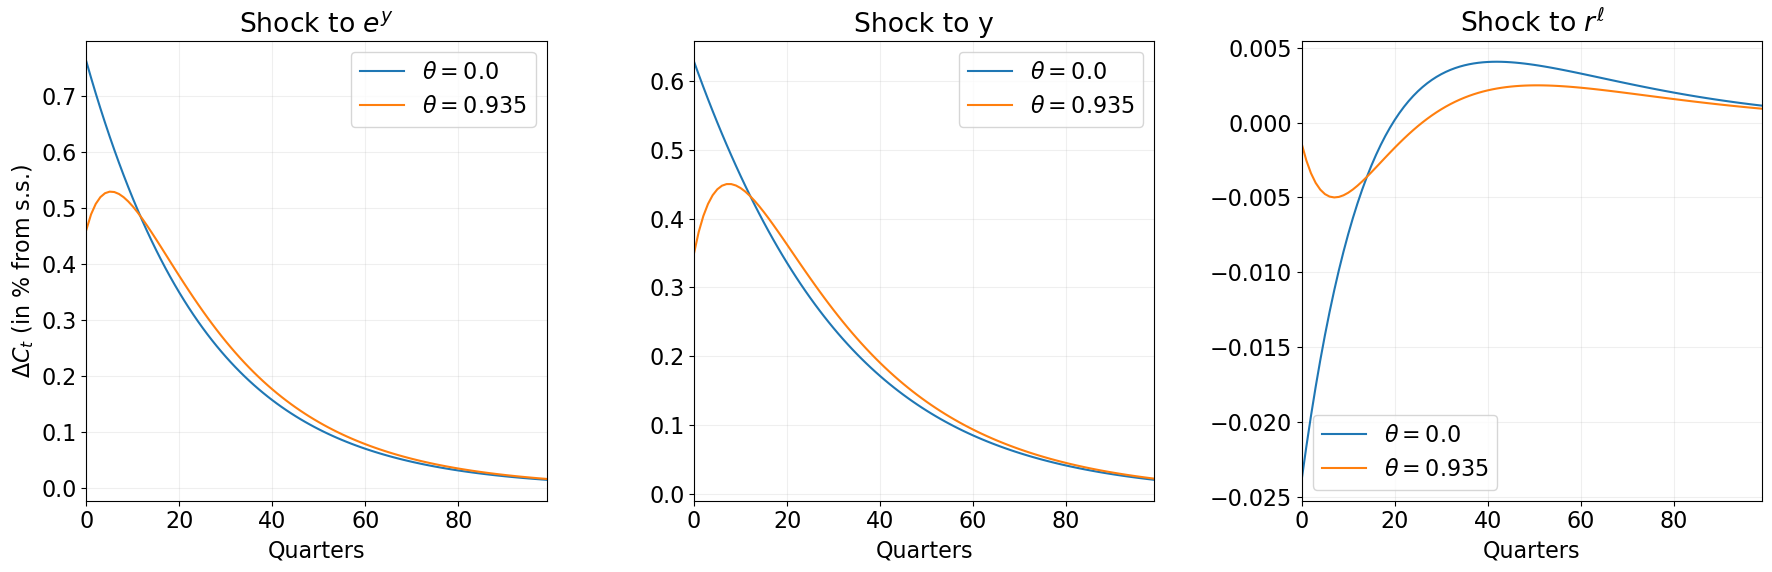

In [8]:
model_list = [model, model_sticky]
label_list = [f'$\\theta = {model_list[0].par.inattention}$', f'$\\theta = {model_list[1].par.inattention}$']
title_list = ['$e^y$', 'y', '$r^{\ell}$']

compare_outputs = ['C_hh']
compare_inputs = ['ey', 'y', 'rl']

plot_periods = 100 # model.par.T

# 1 % jump in income
ss = model_sticky.ss

shocks_jump = [0.01 * ss.y, 0.01 * ss.y, 0.01 * abs(ss.rl)]
shocks_rho = [0.95, 0.95, 0.95]
# shocks_jump = [0.01 * (1 - ss.tau) * ss.wN, -0.01 * ss.tau, 0.01*ss.wN, 0.01 * abs(ss.rl), 0.01 * ss.ra]
# shocks_rho =[0.966, 0.966, 0.966, 0.966, 0.966]

fig = plot_PE_hh(model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, title_list=title_list)
# fig = plotter_PE(fig, [model], ['no intertemp'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, decompose=True)
fig.tight_layout()

# get a list of Axes objects in the figure
axes_list = fig.get_axes()

# iterate over the Axes objects and remove the axis labels
for ax in axes_list[1:]:
    ax.set_ylabel('')

In [9]:
d_ey = shocks_jump[0] * 0.95 ** np.arange(model.par.T)
print(f'A shock with initial jump that corresponds to {shocks_jump[0] / ss.y * 100:.2f}% of labor income and persistence {0.95:.2f} will correspond to an income increase over the full horizon of {d_ey.sum() / ss.y*100:.2f} %')

A shock with initial jump that corresponds to 1.00% of labor income and persistence 0.95 will correspond to an income increase over the full horizon of 20.00 %


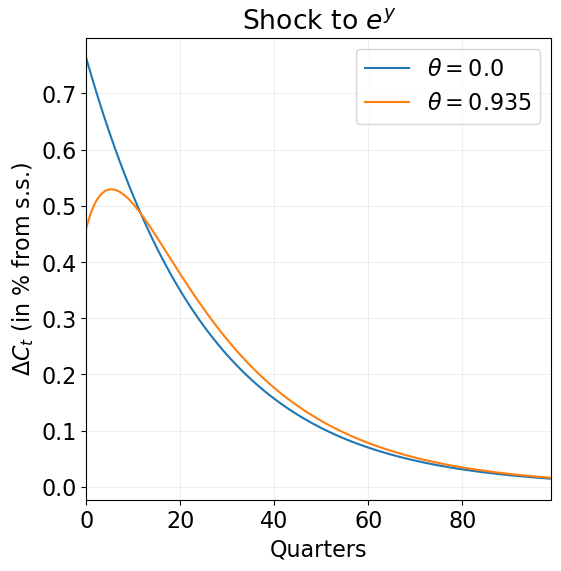

In [10]:
compare_inputs = ['ey']

plot_periods = 100 # model.par.T

# 1 % jump in income
ss = model_sticky.ss

fig = plot_PE_hh(model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, title_list=['$e^y$'])

# Decomposition

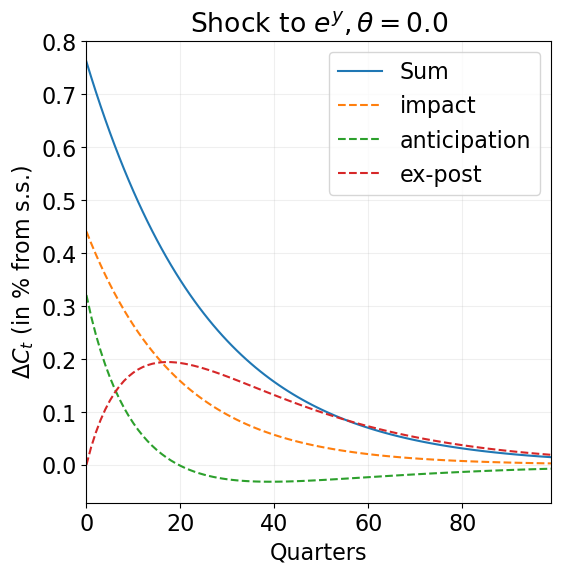

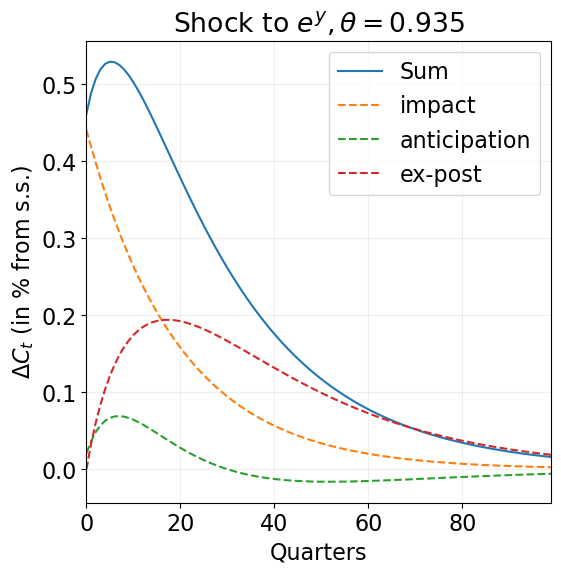

In [11]:
model_list = [model, model_sticky]
label_list = [f'$\\theta = {model_list[0].par.inattention}$', f'$\\theta = {model_list[1].par.inattention}$']

compare_outputs = ['C_hh']
compare_inputs = ['ey']

plot_periods = 100 # model.par.T

# 1 % jump in income
ss = model_sticky.ss

shocks_jump = [0.01 * ss.y]
shocks_rho = [0.95]

# fig = plot_PE_hh(model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)

ncols = len(compare_outputs)
nrows = len(compare_inputs)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), dpi=100)
fig = plotter_PE(fig, [model_list[0]], ['Sum'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho,
                 decompose=True, title_list=[f'$e^y, \\theta = {model_list[0].par.inattention}$'])
nrows = len(compare_outputs)
ncols = len(compare_inputs)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), dpi=100)
fig = plotter_PE(fig, [model_list[1]], ['Sum'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, decompose=True, title_list=[f'$e^y, \\theta = {model_list[1].par.inattention}$'])

In [12]:
model_full_sticky = model.copy()
model_full_sticky.par.inattention = 1.0

model.par.inattention = model_full_sticky.par.inattention
model_full_sticky.jac_hh= model._compute_sticky_jacs_hh(model.jac_hh)
model.par.inattention = 0.0

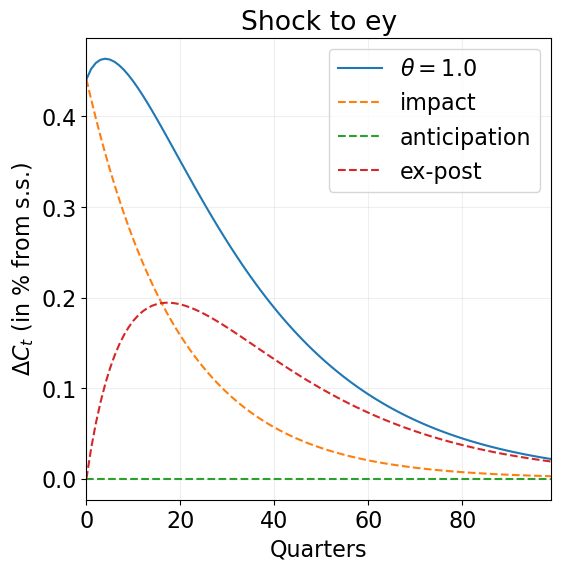

In [13]:
model_list = [model_full_sticky]
label_list = [f'$\\theta = {model_list[0].par.inattention}$']

compare_outputs = ['C_hh']
compare_inputs = ['ey']

plot_periods = 100 # model.par.T

# 1 % jump in income
ss = model_sticky.ss

shocks_jump = [0.01 * ss.y]
shocks_rho = [0.95]

# fig = plot_PE_hh(model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)

ncols = len(compare_outputs)
nrows = len(compare_inputs)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), dpi=100)
fig = plotter_PE(fig, [model_list[0]], [label_list[0]], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho,
                 decompose=True)

# Dependence on persistence
One important note is that the humps are highly dependent on the persistence of the shock. If the shocks are not highly persistent, income and substitution effects are muted and so is the impact of sticky information.

Illustration of this using different persistence levels that all increase aggregate labor income by 5% over different time horizons:

sum of shocks: 0.050
rhos: [0.95, 0.9, 0.8]
jumps: [0.00255, 0.005, 0.01]
jump_hump: 0.00137


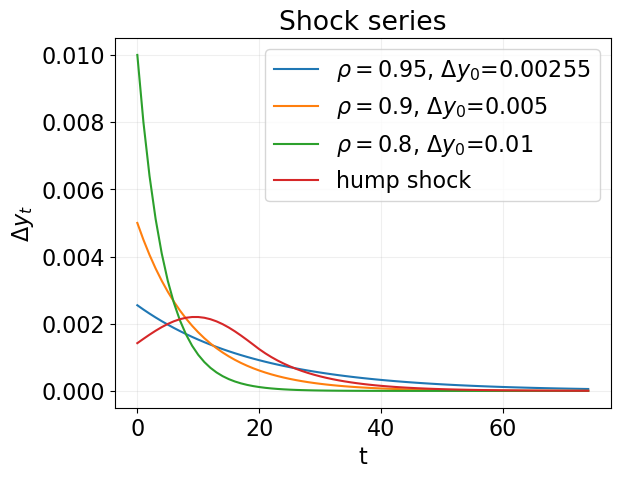

In [31]:
T = 75
T_max = model.par.T
target = 0.05
print(f"sum of shocks: {target:.3f}")


def residual_jump(jump, *args):
    rho, target = args
    shock_series = jump * rho ** np.arange(T)
    return abs(target - sum(shock_series))


def series_hump(T, jump):
    for t in range(T):
        if t < 20:
            rho = (110 - t) / 100
        else:
            rho = 0.9
        if t > 0:
            shock_lag = shock_series[t - 1]
        else:
            shock_lag = jump / 1.06
        shock_series[t] = shock_lag * rho
    return shock_series


def residual_hump(jump, *args):
    T, target = args
    shock_series = series_hump(T, jump)
    return abs(target - sum(shock_series))


rho = [0.95, 0.9, 0.8]

jump = [round(newton(residual_jump, 0.01, args=[r, target]), 5) for r in rho]
print(f'rhos: {rho}')
print(f'jumps: {jump}')

fig, ax = plt.subplots()
ax.set_title("Shock series")
for i_r, r_i in enumerate(rho):
    shock_series = jump[i_r] * r_i ** np.arange(T_max)
    ax.plot(np.arange(T), shock_series[:T], label=f"$\\rho={r_i}$, $\Delta y_0$={jump[i_r]}")

jump_hump = round(newton(residual_hump, 0.01, args=[T, target]), 5)
print(f'jump_hump: {jump_hump}')
shock_series = series_hump(T_max, jump_hump)
ax.plot(np.arange(T), shock_series[:T], label=f"hump shock")

ax.set_xlabel(f't')
ax.set_ylabel('$\Delta y_t$')

ax.legend()
plt.show()

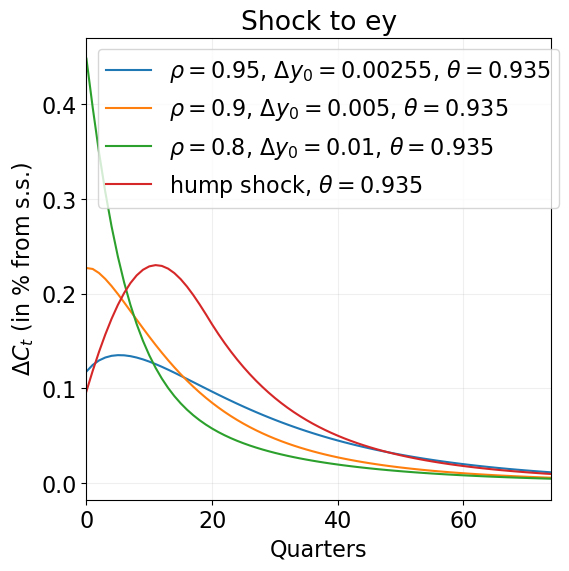

In [32]:
compare_outputs = ['C_hh']
compare_inputs = ['ey']

plot_periods = 75 # model.par.T

# 1 % shocks to ss
ss = model_sticky.ss

jump_init = jump[0]
shocks_jump = [jump_init * ss.y]
shocks_rho = [rho[0]]

fig = plot_PE_hh([model_sticky], [f'$\\rho={rho[0]}$, $\Delta y_0={jump[0]}$, $\\theta={model_sticky.par.inattention}$'],
                 compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)
# fig = plotter_PE(fig, [model], ['$\\rho = 0.966$, $\\theta=0$'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, linestyle='--')

jump_init = jump[1]
shocks_jump = [jump_init * ss.y]
shocks_rho = [rho[1]]

fig = plotter_PE(fig, [model_sticky], [f'$\\rho={rho[1]}$, $\Delta y_0={jump[1]}$, $\\theta={model_sticky.par.inattention}$'],
                 compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)
# fig = plotter_PE(fig, [model], ['$\\rho = 0.9$, $\\theta=0$'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, linestyle='--')

jump_init = jump[2]
shocks_jump = [jump_init * ss.y]
shocks_rho = [rho[2]]

fig = plotter_PE(fig, [model_sticky], [f'$\\rho={rho[2]}$, $\Delta y_0={jump[2]}$, $\\theta={model_sticky.par.inattention}$'],
                 compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)
# fig = plotter_PE(fig, [model], ['$\\rho = 0.8$, $\\theta=0$'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, linestyle='--')


shock_series = series_hump(T, jump_hump)
fig = plotter_PE(fig, [model_sticky], [f'hump shock, $\\theta={model_sticky.par.inattention}$'], compare_outputs,
                 compare_inputs, plot_periods, shock_series=shock_series)



# For Appendix
To-do:
- show responses to rl, ra?
- show how things change with lower MPCs
- distributional effects

## Decomposition for y shock

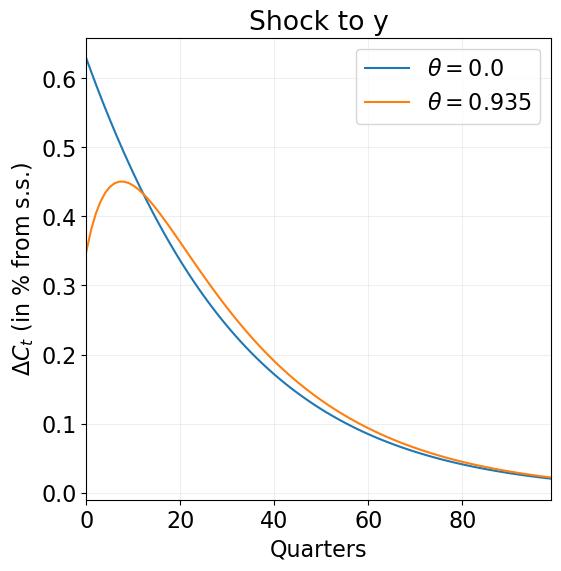

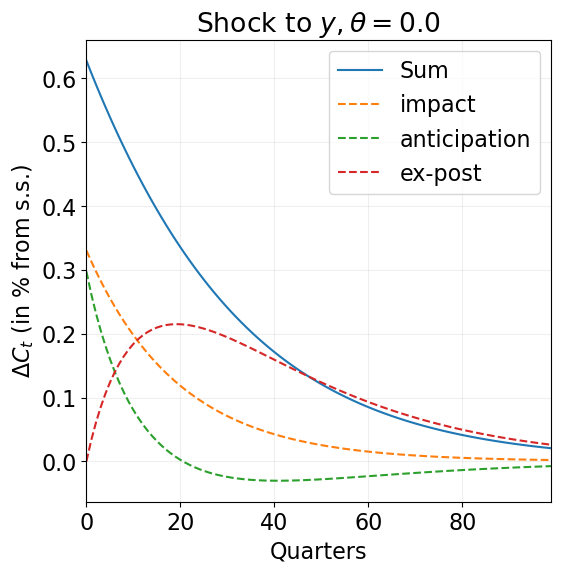

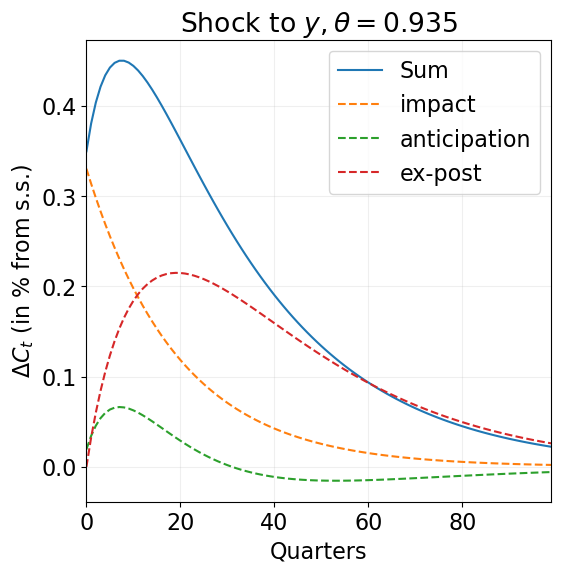

In [19]:
compare_inputs = ['y']

plot_periods = 100  # model.par.T

# 1 % jump in income
ss = model_sticky.ss

model_list = [model, model_sticky]
label_list = [f'$\\theta = {model_list[0].par.inattention}$', f'$\\theta = {model_list[1].par.inattention}$']
fig = plot_PE_hh(model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)


compare_outputs = ['C_hh']

shocks_jump = [0.01 * ss.y]
shocks_rho = [0.95]

# fig = plot_PE_hh(model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)

ncols = len(compare_outputs)
nrows = len(compare_inputs)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), dpi=100)
fig = plotter_PE(fig, [model_list[0]], ['Sum'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, decompose=True, title_list=[f'$y, \\theta = {model_list[0].par.inattention}$'])
nrows = len(compare_outputs)
ncols = len(compare_inputs)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), dpi=100)
fig = plotter_PE(fig, [model_list[1]], ['Sum'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, decompose=True, title_list=[f'$y, \\theta = {model_list[1].par.inattention}$'])

In [20]:
def decomp_no_plot(model, output_input, shock_series, ss_value):
    jac = model.jac_hh[output_input]

    # get hh jacs for theta = 1
    model_full_sticky = model.copy()
    if model.par.inattention > 0.0:
        model_full_sticky = model.copy()
        model_full_sticky.par.inattention = 0.0
        model_full_sticky._compute_jac_hh()
    model_full_sticky.par.inattention = 1.0
    jac_full_sticky = model_full_sticky._compute_sticky_jacs_hh(model_full_sticky.jac_hh)
    jac_full_sticky = jac_full_sticky[output_input]

    # Direct impact effect of shock
        # All elements except the diagonal to zero.
    jac_direct = np.diag(np.diag(jac_full_sticky))

    # Ex-post distributional effects
        # Elements on and above diagonal to zero.
    jac_post = jac_full_sticky.copy()
    for t in range(jac_post.shape[0]):
        jac_post[t,t] = 0.0

    # Anticipation effects
    jac_anticipation = jac - jac_direct - jac_post

    IRF = jac @ shock_series
    IRF_direct = jac_direct @ shock_series
    IRF_expost = jac_post @ shock_series
    IRF_anticip = jac_anticipation @ shock_series
    return IRF, IRF_direct, IRF_expost, IRF_anticip

In [21]:
shock_series =  shocks_jump[0]*shocks_rho[0]**np.arange(model.par.T)
IRF_ey, IRF_ey_direct, IRF_ey_expost, IRF_ey_anticip = decomp_no_plot(model, ('C_hh', 'ey'), shock_series, model.ss)
IRF_y, IRF_y_direct, IRF_y_expost, IRF_y_anticip = decomp_no_plot(model, ('C_hh', 'y'), shock_series, model.ss)

In [25]:
np.array([IRF_ey, IRF_ey_direct/IRF_ey*100, IRF_ey_expost/IRF_ey*100, IRF_ey_anticip/IRF_ey*100, IRF_y, IRF_y_direct/IRF_y*100, IRF_y_expost/IRF_y*100, IRF_y_anticip/IRF_y*100]).T

array([[ 5.34893152e-03,  5.78806768e+01,  0.00000000e+00, ...,
         5.26179108e+01,  0.00000000e+00,  4.73820892e+01],
       [ 5.14695313e-03,  5.71444465e+01,  4.56305401e+00, ...,
         5.15126250e+01,  5.31794978e+00,  4.31694252e+01],
       [ 4.95219285e-03,  5.64222369e+01,  8.65154174e+00, ...,
         5.04378630e+01,  1.01571346e+01,  3.94050024e+01],
       ...,
       [ 2.54431988e-07,  3.82788985e+00,  1.72498506e+02, ...,
         1.63964048e+00,  1.45187996e+02, -4.68276368e+01],
       [ 2.44126257e-07,  3.79000914e+00,  1.72763674e+02, ...,
         1.62206089e+00,  1.45310153e+02, -4.69322143e+01],
       [ 2.34219059e-07,  3.75280607e+00,  1.73041865e+02, ...,
         1.60477838e+00,  1.45440873e+02, -4.70456513e+01]])

In [27]:
np.array([IRF_ey.sum(), IRF_ey_direct.sum()/IRF_ey.sum()*100, IRF_ey_expost.sum()/IRF_ey.sum()*100, IRF_ey_anticip.sum()/IRF_ey.sum()*100, IRF_y.sum(), IRF_y_direct.sum()/IRF_y.sum()*100, IRF_y_expost.sum()/IRF_y.sum()*100, IRF_y_anticip.sum()/IRF_y.sum()*100])

array([ 0.13809028, 44.84007854, 52.89539206,  2.26452941,  0.13599641,
       34.10866007, 63.58784789,  2.30349203])

In [28]:
np.array([IRF_ey.__abs__().sum(), IRF_ey_direct.__abs__().sum()/IRF_ey.__abs__().sum()*100, IRF_ey_expost.__abs__().sum()/IRF_ey.__abs__().sum()*100, IRF_ey_anticip.__abs__().sum()/IRF_ey.__abs__().sum()*100, IRF_y.__abs__().sum(), IRF_y_direct.__abs__().sum()/IRF_y.__abs__().sum()*100, IRF_y_expost.__abs__().sum()/IRF_y.__abs__().sum()*100, IRF_y_anticip.__abs__().sum()/IRF_y.__abs__().sum()*100])

array([ 0.13809028, 44.84007854, 52.89539206, 20.54707122,  0.13599641,
       34.10866007, 63.58784789, 20.39528023])

## Theta sensitivity

In [64]:
def decompose_PE_sensitivity_theta(model, output_input, shock_series, theta_list ,plot_periods, ss_value, title=None):

    fig = plt.figure(figsize=(6*2, 6), dpi=100)
    ax_IRF = fig.add_subplot(1,2,1)
    ax = fig.add_subplot(1,2,2)

    shock = output_input[1]
    if title == None:
        title  = f'Shock to {shock}'

    model_no_sticky = model.copy()
    if model.par.inattention > 0.0:
        model_no_sticky = model.copy()
        model_no_sticky.par.inattention = 0.0
        model_no_sticky._compute_jac_hh()
    model_no_sticky.par.inattention = 1.0
    jac_full_sticky = model_no_sticky._compute_sticky_jacs_hh(model_no_sticky.jac_hh)
    jac_full_sticky = jac_full_sticky[output_input]

    # Direct impact effect of shock
        # All elements except the diagonal to zero.
    jac_direct = np.diag(np.diag(jac_full_sticky))

    # Ex-post distributional effects
        # Elements on and above diagonal to zero.
    jac_post = jac_full_sticky.copy()
    for t in range(jac_post.shape[0]):
        jac_post[t,t] = 0.0

    IRF_direct = jac_direct @ shock_series
    IRF_expost = jac_post @ shock_series

    for theta in theta_list:

        model_temp = model_no_sticky.copy()
        model_temp.par.inattention = theta
        jac = model_temp._compute_sticky_jacs_hh(model_temp.jac_hh)
        jac = jac[output_input]

        # Anticipation effects
        jac_anticipation = jac - jac_direct - jac_post

        IRF = jac @ shock_series

        IRF_anticip = jac_anticipation @ shock_series

        assert np.isclose(IRF - (IRF_direct + IRF_anticip + IRF_expost), 0.0).all()

        ax_IRF.plot(np.arange(plot_periods), (IRF[:plot_periods] / ss_value)*100, label=f"$\\theta={theta}$", linestyle="-")

        ax.plot(np.arange(plot_periods), (IRF_anticip[:plot_periods] / ss_value)*100, label=f"$\\theta={theta}$", linestyle="-")

    ax_IRF.set_title(title)
    # ax.set_title(f'{shock}_shock on {output} (in %)')
    ax_IRF.set_xlabel('Quarters')
    ax_IRF.set_ylabel(f'$\Delta C_t$ (in % of $C^{{ss}}$)')
    ax_IRF.legend()

    ax.set_title('Anticipation effect')
    # ax.set_title(f'{shock}_shock on {output} (in %)')
    ax.set_xlabel('Quarters')
    # ax.set_ylabel(f'$\Delta C_t$ (in % of $C^{{ss}}$)')
    # ax.legend()
    fig.tight_layout()

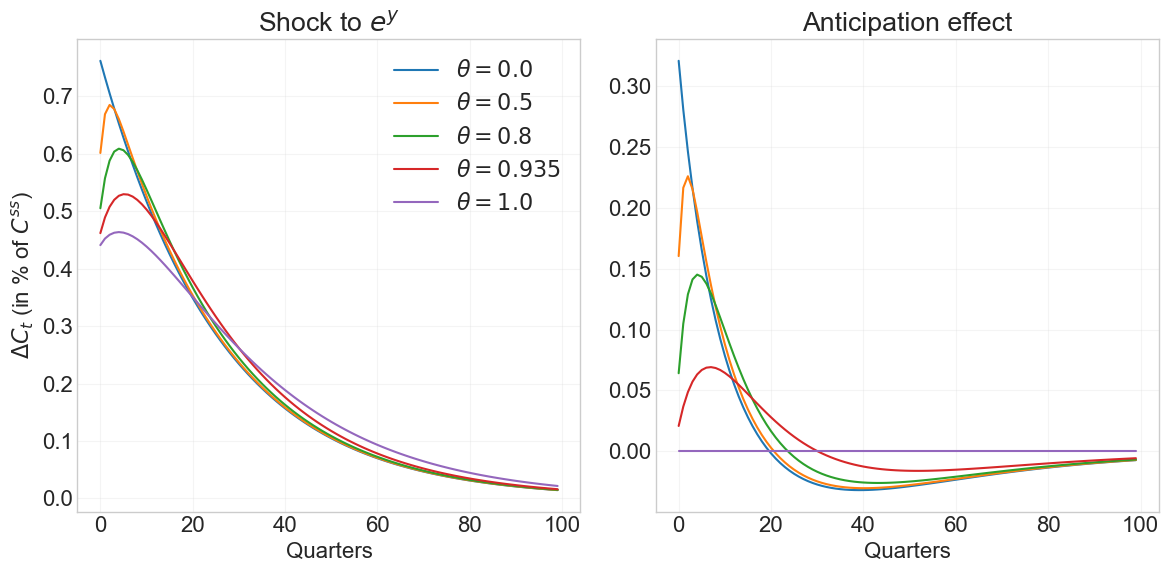

In [65]:
shocks_jump = [0.01 * ss.y]
shocks_rho = [0.95]

T = model.par.T
shock_series =  shocks_jump[0]*shocks_rho[0]**np.arange(T)
ss_value = model.ss.__dict__['C_hh']
plot_periods = 100

theta_list = [0.0, 0.5, 0.8, 0.935, 1.0]

decompose_PE_sensitivity_theta(model, ('C_hh', 'ey'), shock_series, theta_list ,plot_periods, ss_value, title=f'Shock to $e^y$')

## iMPCs

In [55]:
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

def plot_jacs(model, s_list=None, dx=1e-4, inputs_outputs=[], max_T=model.par.T, inattention=0.935):
    """ compute and plot hh Jacobians with direct and fake news method
        - difference to GEModelTools function: plot only selected Jacobians.

        :param input_output: Jacobians to plot as list of elements in the form of ('outputname', 'inputname')."""

    model_jac_temp = deepcopy(model.jac_hh)    # save original model jacs and replace again later as not all Jacobians might be caluclated

    if s_list is None:
        s_list = list(np.arange(0, max_T, max_T // 4))

    if len(inputs_outputs) > 0:
        inputs_hh_all = set([inp[1] for inp in plot_list if inp[1]])
    else:
        inputs_hh_all = model.inputs_hh_all

    # a. no sticky jacs
    if model.par.inattention == 0:
        jac_hh_no_sticky = model.jac_hh
    else:
        jac_hh_save = model.jac_hh
        model._compute_jac_hh(dx=dx, do_print=True, do_direct=True, s_list=s_list, inputs_hh_all=inputs_hh_all)
        jac_hh_sticky = model.jac_hh
        model.jac_hh = jac_hh_save

    # b. sticky
    if model.par.inattention == inattention:
        jac_hh_sticky = model.jac_hh
    else:
        inattention_save = model.par.inattention

        model.par.inattention = inattention
        jac_hh_sticky = model._compute_sticky_jacs_hh(model.jac_hh)

        model.par.inattention = inattention_save

    # c. compare

    def jac_add_subplot(input_output, n_inputs_outputs):
        jac_hh_var_no_sticky = jac_hh_no_sticky[input_output]
        jac_hh_var = jac_hh_sticky[input_output]

        ax1 = fig.add_subplot(n_inputs_outputs, 3, i * 2 + 1)
        ax2 = fig.add_subplot(n_inputs_outputs, 3, i * 2 + 2)
        ax_diff = fig.add_subplot(n_inputs_outputs, 3, i * 2 + 3)

        # ax.set_title(f'Jac {input_output}')
        # ax_diff.set_title('$\partial C_t^{FI} / \partial y_s - \partial C_t / \partial y_s$')

        for j, s in enumerate(s_list):
            ax1.plot(np.arange(max_T), jac_hh_var_no_sticky[:max_T, s], color=colors[j], label=f's = {s}')
            ax2.plot(np.arange(max_T), jac_hh_var[:max_T, s], color=colors[j], ls='-', label=f's = {s}')
            ax1.set_xlabel('Quarters')
            ax2.set_xlabel('Quarters')
            # ax.set_ylabel(f'$\partial C_t / \partial y_s$')
            ax1.set_ylabel('$J_{t,s}^{C,e^y,0}$')
            ax2.set_ylabel('$J_{t,s}^{C,e^y,\\theta}$')

            diff = jac_hh_var[:max_T, s] - jac_hh_var_no_sticky[:max_T, s]
            ax_diff.plot(np.arange(max_T), diff, color=colors[j], label=f's = {s}')
            ax_diff.set_xlabel('Quarters')
            # ax_diff.set_ylabel('$\partial C_t^{FI} / \partial y_s - \partial C_t / \partial y_s$')
            ax_diff.set_ylabel('$J_{t,s}^{C,e^y,0} - J_{t,s}^{C,e^y,\\theta}$')

            # list_diffs.append([
            #     f'{input_output}, s = {s}',
            #     abs(diff).max(),
            #     (abs(diff).max()/ abs(jac_hh_var_no_sticky[abs(diff).argmax(), s])) * 100
            # ])

        return ax1, ax2, ax_diff

    i = 0

    if len(inputs_outputs) == 0:
        fig = plt.figure(figsize=(6 * 3, len(model.outputs_hh) * len(model.inputs_hh_all) * 4), dpi=100)

        n_inputs_outputs = len(model.inputs_hh_all) * len(model.outputs_hh)
        for inputname in model.inputs_hh_all:
            for outputname in model.outputs_hh:

                input_output = (f'{outputname.upper()}_hh', inputname)

                ax1, ax2, ax_diff = jac_add_subplot(input_output, n_inputs_outputs)

                if i == 0:
                    ax.legend(frameon=True)
                    ax_diff.legend(frameon=True)
                i += 1
    else:
        fig = plt.figure(figsize=(6 * 3, len(inputs_outputs)*4), dpi=100)

        n_inputs_outputs = len(inputs_outputs)
        for input_output in inputs_outputs:

            ax1, ax2, ax_diff = jac_add_subplot(input_output, n_inputs_outputs)

            if i == 0:
                ax1.legend(frameon=True)
                ax2.legend(frameon=True)
                ax_diff.legend(frameon=True)
            i += 1

    model.jac_hh = model_jac_temp

    fig.tight_layout()


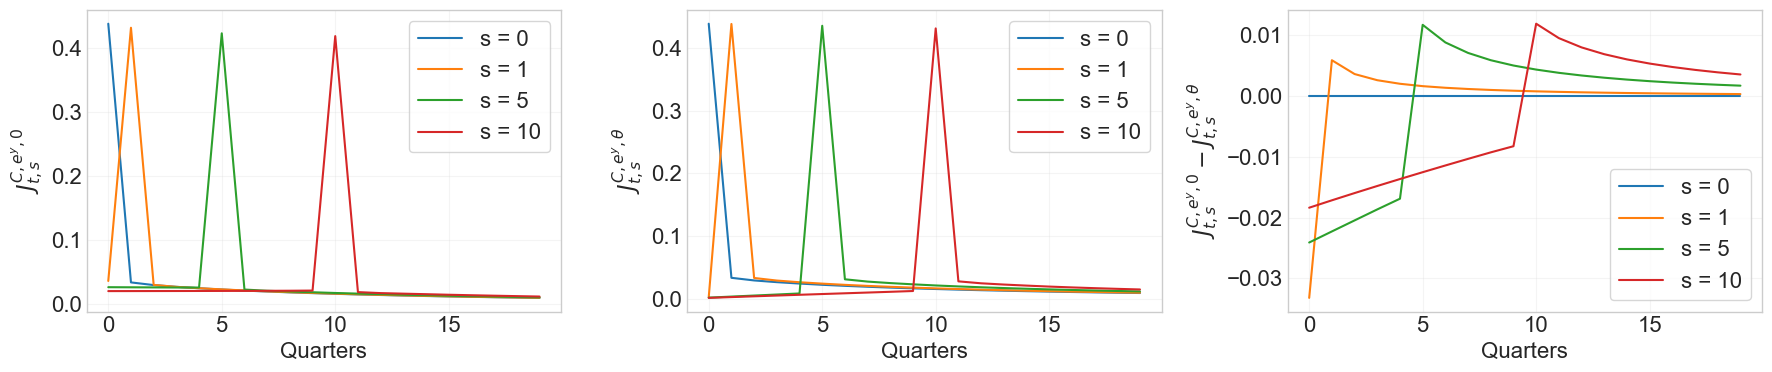

In [56]:
s_list = [0,1,5,10]
plot_list = [('C_hh', 'ey')]
plot_jacs(model, s_list=s_list, max_T=20, inputs_outputs=plot_list, inattention=0.935)

## Aggregate income changes

shock to ['y'] by 0.1 % initially


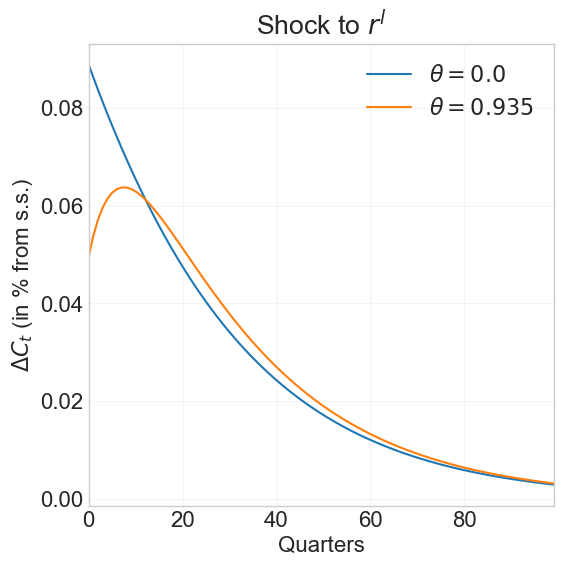

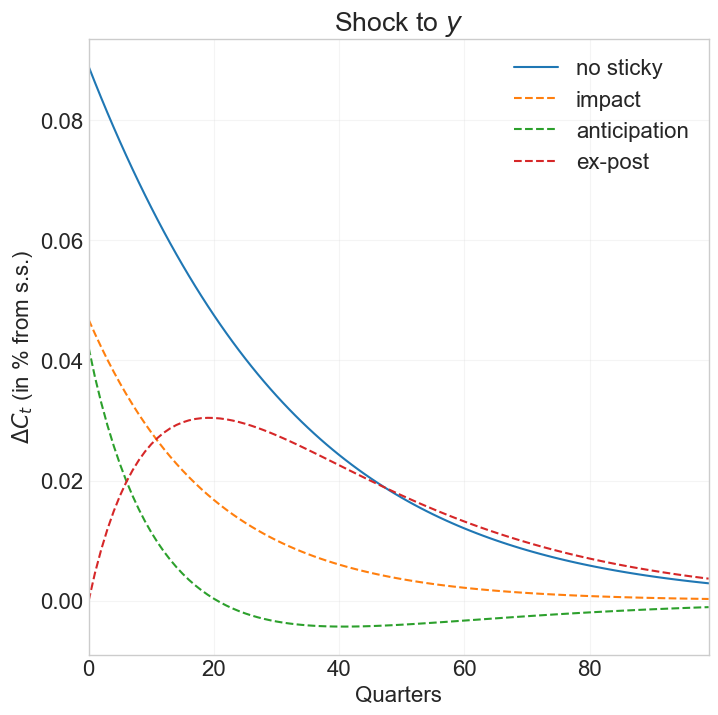

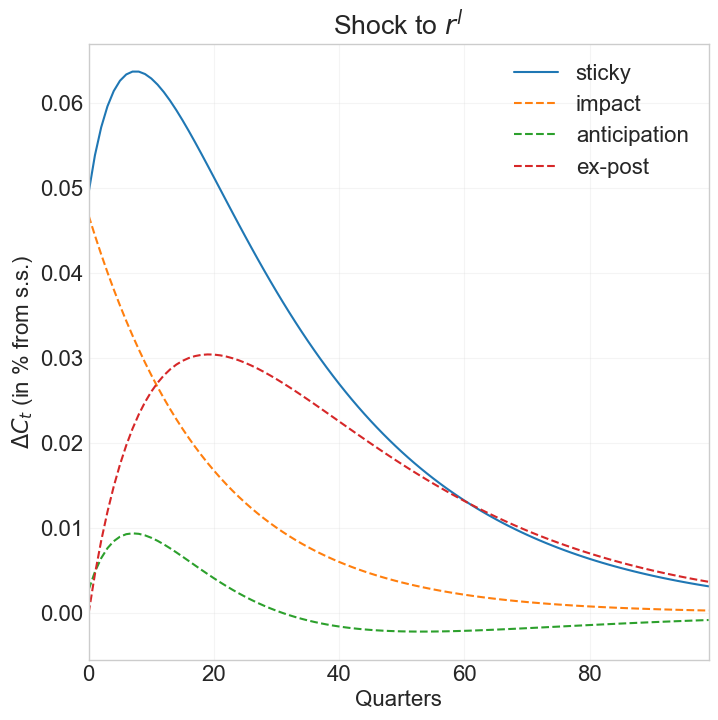

In [39]:
model_list = [model, model_sticky]
label_list = [f'$\\theta = {model_list[0].par.inattention}$', f'$\\theta = {model_list[1].par.inattention}$']

compare_outputs = ['C_hh']
compare_inputs = ['y']

plot_periods = 100  # model.par.T

# 1 % jump in income
ss = model_sticky.ss

shocks_jump = [0.001]
shocks_rho = [0.95]

print(f'shock to {compare_inputs} by {shocks_jump[0]*100} % initially')

fig = plot_PE_hh(model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, title_list=['$r^l$', '$y$'])

nrows = len(compare_outputs)
ncols = len(compare_inputs)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 8 * nrows), dpi=100)
fig = plotter_PE(fig, [model], ['no sticky'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho,
                 decompose=True, title_list=['$y$'])
nrows = len(compare_outputs)
ncols = len(compare_inputs)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 8 * nrows), dpi=100)
fig = plotter_PE(fig, [model_sticky], ['sticky'], compare_outputs, compare_inputs, plot_periods, shocks_jump,
                 shocks_rho, decompose=True, title_list=['$r^l$'])

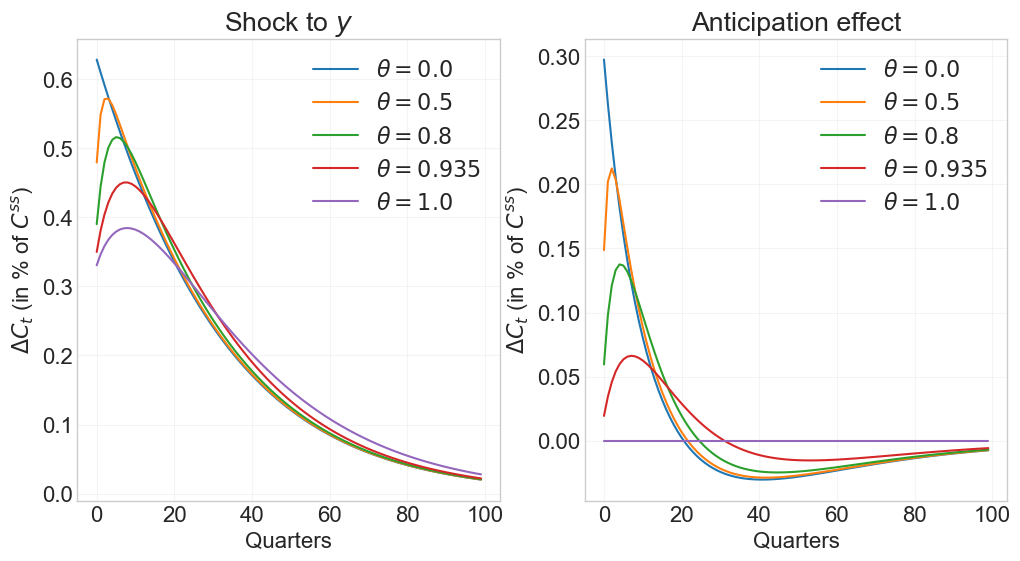

In [40]:
shocks_jump = [0.01 * ss.y]
shocks_rho = [0.95]

T = model.par.T
shock_series =  shocks_jump[0]*shocks_rho[0]**np.arange(T)
ss_value = model.ss.__dict__['C_hh']
plot_periods = 100

theta_list = [0.0, 0.5, 0.8, 0.935, 1.0]

decompose_PE_sensitivity_theta(model, ('C_hh', 'y'), shock_series, theta_list ,plot_periods, ss_value, title=f'Shock to $y$')

## Interest rate changes

shock to ['rl'] by 0.1 % initially


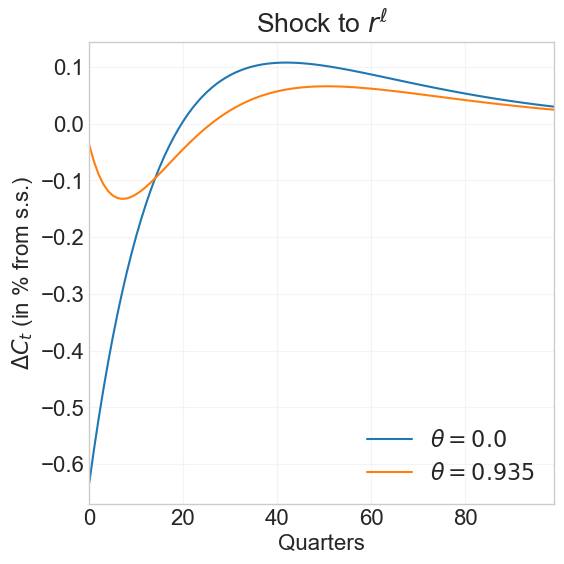

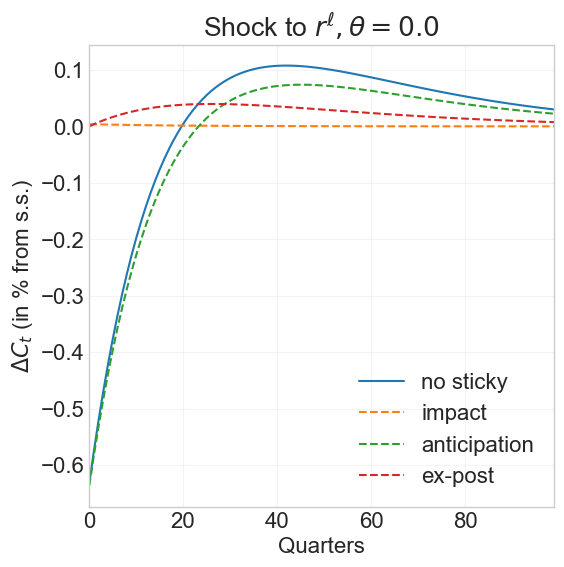

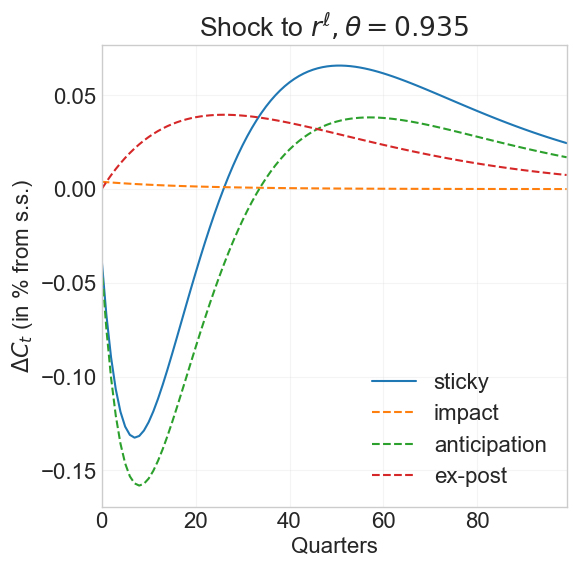

In [69]:
model_list = [model, model_sticky]
label_list = [f'$\\theta = {model_list[0].par.inattention}$', f'$\\theta = {model_list[1].par.inattention}$']

compare_outputs = ['C_hh']
compare_inputs = ['rl']

plot_periods = 100  # model.par.T

# 1 % jump in income
ss = model_sticky.ss

shocks_jump = [0.001]
shocks_rho = [0.95]

print(f'shock to {compare_inputs} by {shocks_jump[0]*100} % initially')

fig = plot_PE_hh(model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, title_list=['$r^{\ell}$', '$r^{\ell}$'])
axes_list = fig.get_axes()
for ax in axes_list:
    ax.legend(loc='lower right')

nrows = len(compare_outputs)
ncols = len(compare_inputs)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), dpi=100)
fig = plotter_PE(fig, [model], ['no sticky'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho,
                 decompose=True, title_list=[f'$r^{{\ell}}, \\theta={model.par.inattention}$'])
nrows = len(compare_outputs)
ncols = len(compare_inputs)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), dpi=100)
fig = plotter_PE(fig, [model_sticky], ['sticky'], compare_outputs, compare_inputs, plot_periods, shocks_jump,
                 shocks_rho, decompose=True, title_list=[f'$r^{{\ell}}, \\theta={model_sticky.par.inattention}$'])

axes_list = fig.get_axes()
for ax in axes_list:
    ax.legend(loc='lower right')

In [42]:
0.55/-0.6 * 100

-91.66666666666667

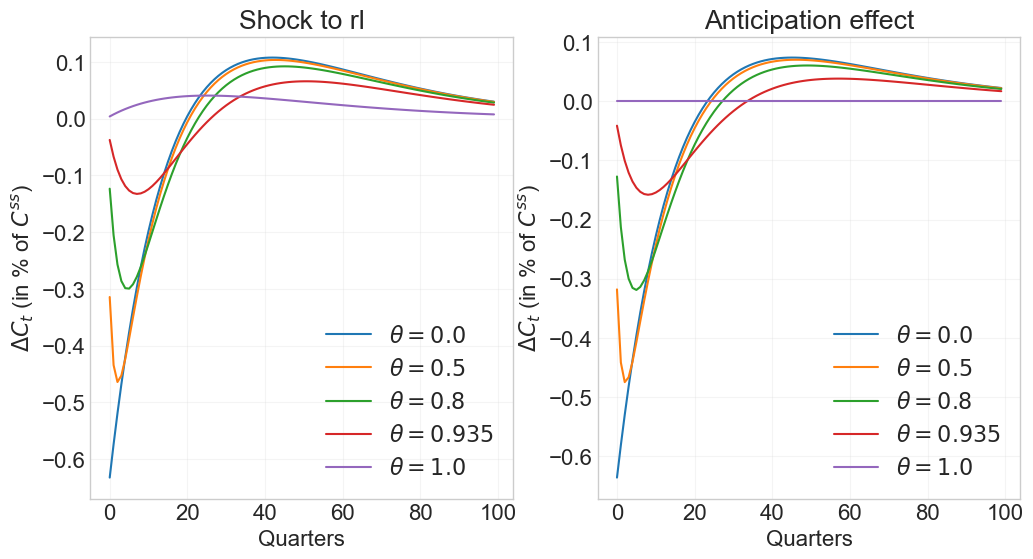

In [43]:
T = model.par.T
shock_series =  shocks_jump[0]*shocks_rho[0]**np.arange(T)
ss_value = model.ss.__dict__['C_hh']
plot_periods = 100

theta_list = [0.0, 0.5, 0.8, 0.935, 1.0]

decompose_PE_sensitivity_theta(model, ('C_hh', 'rl'), shock_series, theta_list ,plot_periods, ss_value)

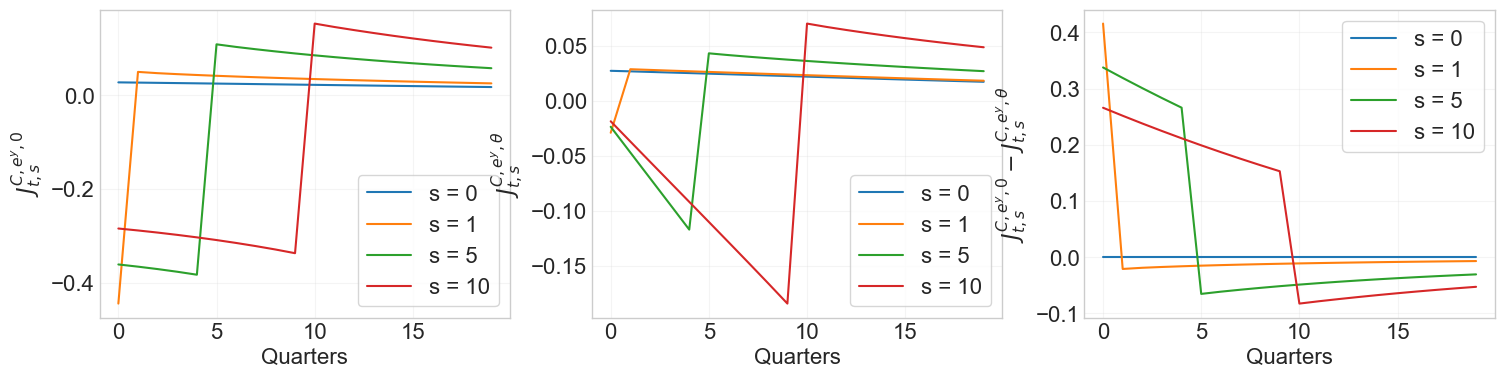

In [44]:
s_list = [0,1,5,10]
plot_list = [('C_hh', 'rl')]
plot_jacs(model, s_list=s_list, max_T=20, inputs_outputs=plot_list, inattention=0.935)

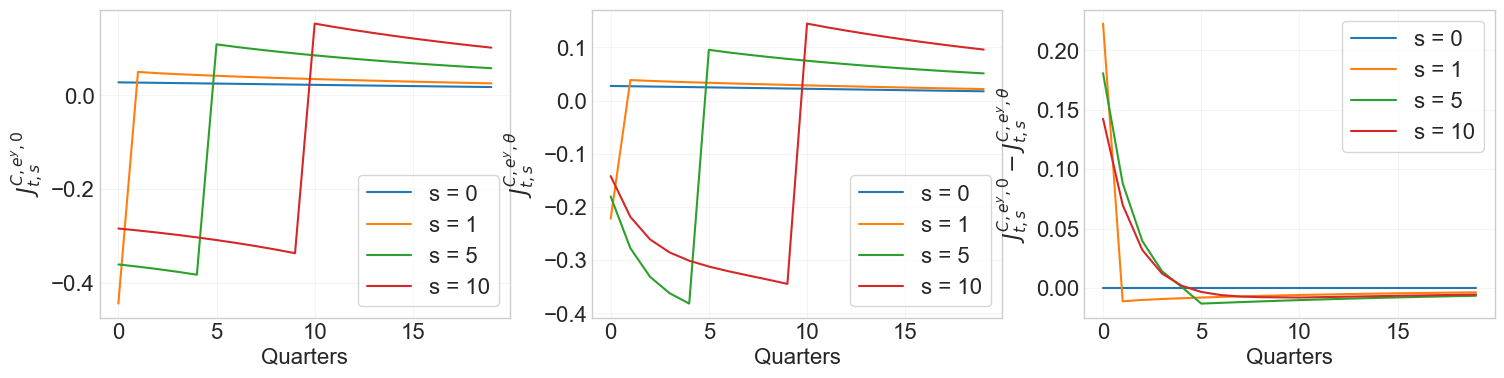

In [45]:
plot_jacs(model, s_list=s_list, max_T=20, inputs_outputs=plot_list, inattention=0.5)

sum of shocks: 0.050
rhos: [0.95, 0.9, 0.8]
jumps: [0.00255, 0.005, 0.01]
jump_hump: 0.00137


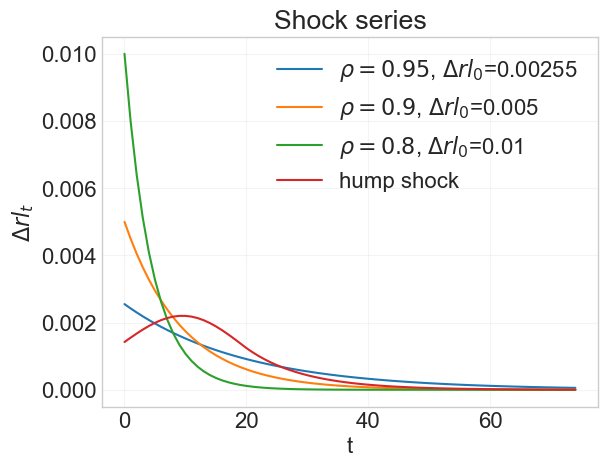

In [46]:
T = 75
T_max = model.par.T
target = 0.05
print(f"sum of shocks: {target:.3f}")


def residual_jump(jump, *args):
    rho, target = args
    shock_series = jump * rho ** np.arange(T)
    return abs(target - sum(shock_series))


def series_hump(T, jump):
    for t in range(T):
        if t < 20:
            rho = (110 - t) / 100
        else:
            rho = 0.9
        if t > 0:
            shock_lag = shock_series[t - 1]
        else:
            shock_lag = jump / 1.06
        shock_series[t] = shock_lag * rho
    return shock_series


def residual_hump(jump, *args):
    T, target = args
    shock_series = series_hump(T, jump)
    return abs(target - sum(shock_series))


rho = [0.95, 0.9, 0.8]

jump = [round(newton(residual_jump, 0.01, args=[r, target]), 5) for r in rho]
print(f'rhos: {rho}')
print(f'jumps: {jump}')

fig, ax = plt.subplots()
ax.set_title("Shock series")
for i_r, r_i in enumerate(rho):
    shock_series = jump[i_r] * r_i ** np.arange(T_max)
    ax.plot(np.arange(T), shock_series[:T], label=f"$\\rho={r_i}$, $\Delta rl_0$={jump[i_r]}")

jump_hump = round(newton(residual_hump, 0.01, args=[T, target]), 5)
print(f'jump_hump: {jump_hump}')
shock_series = series_hump(T_max, jump_hump)
ax.plot(np.arange(T), shock_series[:T], label=f"hump shock")

ax.set_xlabel(f't')
ax.set_ylabel('$\Delta rl_t$')

ax.legend()
plt.show()

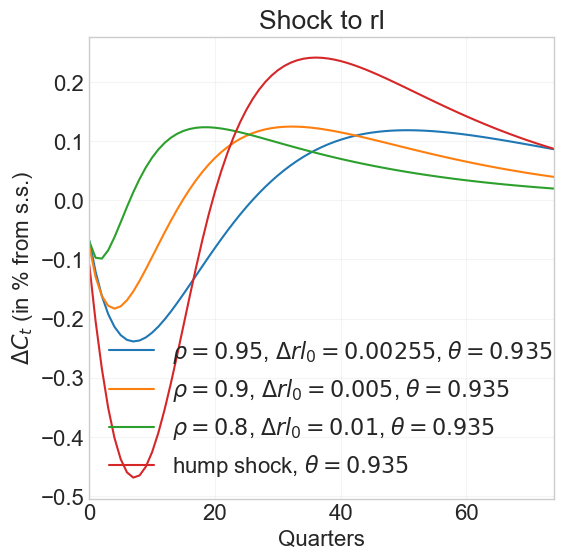

In [47]:
compare_outputs = ['C_hh']
compare_inputs = ['rl']

plot_periods = 75 # model.par.T

# 1 % shocks to ss
ss = model_sticky.ss

jump_init = jump[0]
shocks_jump = [jump_init * ss.y]
shocks_rho = [rho[0]]

fig = plot_PE_hh([model_sticky], [f'$\\rho={rho[0]}$, $\Delta rl_0={jump[0]}$, $\\theta={model_sticky.par.inattention}$'],
                 compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)
# fig = plotter_PE(fig, [model], ['$\\rho = 0.966$, $\\theta=0$'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, linestyle='--')

jump_init = jump[1]
shocks_jump = [jump_init * ss.y]
shocks_rho = [rho[1]]

fig = plotter_PE(fig, [model_sticky], [f'$\\rho={rho[1]}$, $\Delta rl_0={jump[1]}$, $\\theta={model_sticky.par.inattention}$'],
                 compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)
# fig = plotter_PE(fig, [model], ['$\\rho = 0.9$, $\\theta=0$'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, linestyle='--')

jump_init = jump[2]
shocks_jump = [jump_init * ss.y]
shocks_rho = [rho[2]]

fig = plotter_PE(fig, [model_sticky], [f'$\\rho={rho[2]}$, $\Delta rl_0={jump[2]}$, $\\theta={model_sticky.par.inattention}$'],
                 compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)
# fig = plotter_PE(fig, [model], ['$\\rho = 0.8$, $\\theta=0$'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, linestyle='--')


shock_series = series_hump(T, jump_hump)
fig = plotter_PE(fig, [model_sticky], [f'hump shock, $\\theta={model_sticky.par.inattention}$'], compare_outputs,
                 compare_inputs, plot_periods, shock_series=shock_series)



## More graphs on persistence

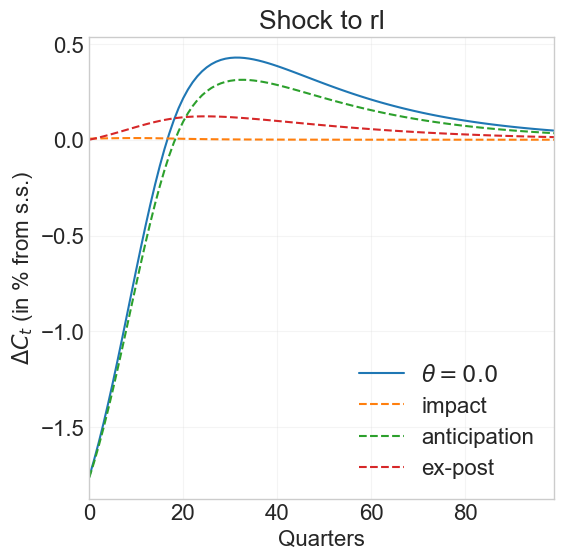

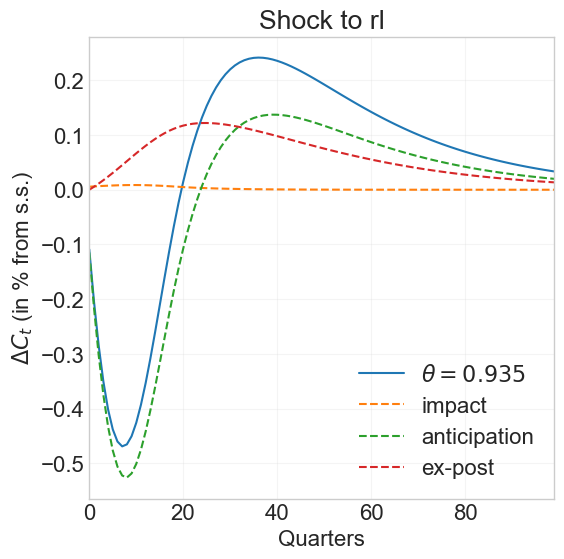

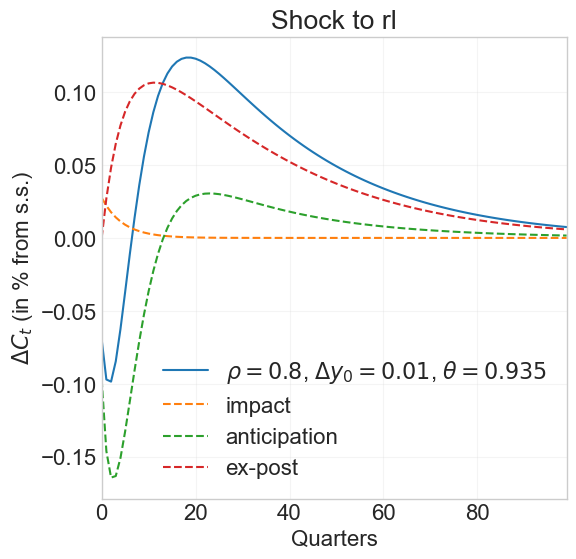

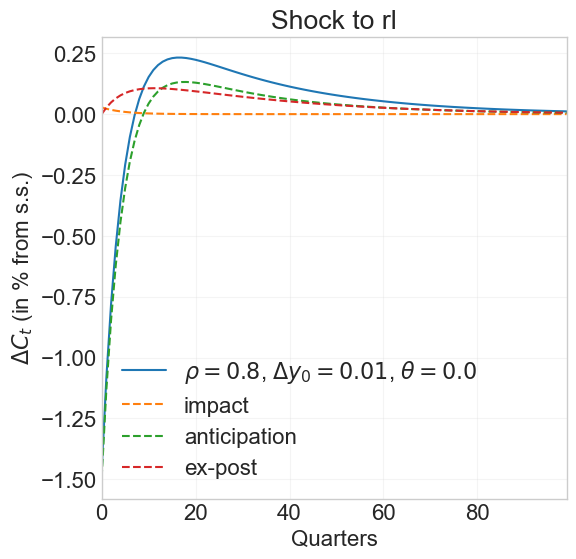

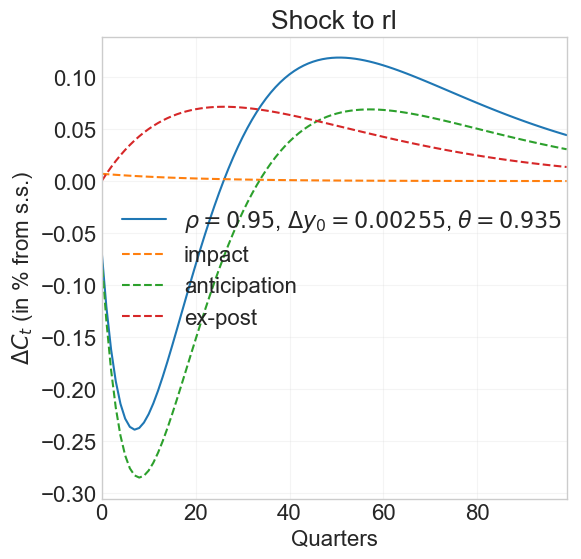

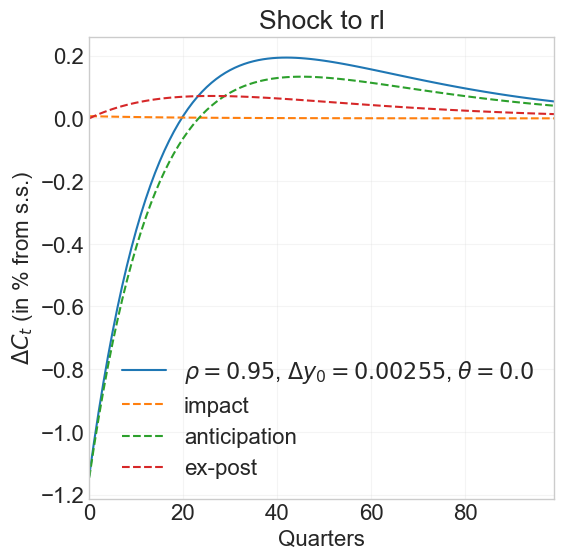

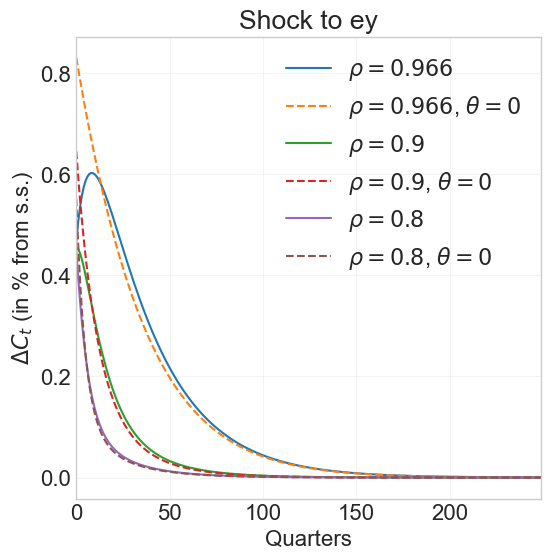

In [48]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), dpi=100)
fig = plotter_PE(fig, [model], [f'$\\theta = {model.par.inattention}$'], compare_outputs, compare_inputs,
                 plot_periods=100, shock_series=shock_series,
                 decompose=True)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), dpi=100)
fig = plotter_PE(fig, [model_sticky], [f'$\\theta = {model_sticky.par.inattention}$'], compare_outputs, compare_inputs,
                 plot_periods=100, shock_series=shock_series,
                 decompose=True)
jump_init = jump[2]
shocks_jump = [jump_init * ss.y]
shocks_rho = [rho[2]]

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), dpi=100)
fig = plotter_PE(fig, [model_sticky],
                 [f'$\\rho={rho[2]}$, $\Delta y_0={jump[2]}$, $\\theta={model_sticky.par.inattention}$'],
                 compare_outputs, compare_inputs, 100, shocks_jump, shocks_rho, decompose=True)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), dpi=100)
fig = plotter_PE(fig, [model], [f'$\\rho={rho[2]}$, $\Delta y_0={jump[2]}$, $\\theta={model.par.inattention}$'],
                 compare_outputs, compare_inputs, 100, shocks_jump, shocks_rho, decompose=True)
jump_init = jump[0]
shocks_jump = [jump_init * ss.y]
shocks_rho = [rho[0]]

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), dpi=100)
fig = plotter_PE(fig, [model_sticky],
                 [f'$\\rho={rho[0]}$, $\Delta y_0={jump[0]}$, $\\theta={model_sticky.par.inattention}$'],
                 compare_outputs, compare_inputs, 100, shocks_jump, shocks_rho, decompose=True)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), dpi=100)
fig = plotter_PE(fig, [model], [f'$\\rho={rho[0]}$, $\Delta y_0={jump[0]}$, $\\theta={model.par.inattention}$'],
                 compare_outputs, compare_inputs, 100, shocks_jump, shocks_rho, decompose=True)
compare_outputs = ['C_hh']
compare_inputs = ['ey']

plot_periods = model.par.T

# 1 % jump in income
ss = model_sticky.ss

shocks_jump = [0.01 * ss.y]
shocks_rho = [0.966]

fig = plot_PE_hh([model_sticky], ['$\\rho = 0.966$'], compare_outputs, compare_inputs, plot_periods, shocks_jump,
                 shocks_rho)
fig = plotter_PE(fig, [model], ['$\\rho = 0.966$, $\\theta=0$'], compare_outputs, compare_inputs, plot_periods,
                 shocks_jump, shocks_rho, linestyle='--')

shocks_rho = [0.9]
fig = plotter_PE(fig, [model_sticky], ['$\\rho = 0.9$'], compare_outputs, compare_inputs, plot_periods, shocks_jump,
                 shocks_rho)
fig = plotter_PE(fig, [model], ['$\\rho = 0.9$, $\\theta=0$'], compare_outputs, compare_inputs, plot_periods,
                 shocks_jump, shocks_rho, linestyle='--')
# #
shocks_rho = [0.8]
fig = plotter_PE(fig, [model_sticky], ['$\\rho = 0.8$'], compare_outputs, compare_inputs, plot_periods, shocks_jump,
                 shocks_rho)
fig = plotter_PE(fig, [model], ['$\\rho = 0.8$, $\\theta=0$'], compare_outputs, compare_inputs, plot_periods,
                 shocks_jump, shocks_rho, linestyle='--')

## Dependence hump on MPC targets

In [49]:
model_04 = HAsimpleModel.HAsimpleModelClass(par={'MPC_target': 0.4, 'beta_mean': 0.9923329545899056})
model_02 = HAsimpleModel.HAsimpleModelClass(par={'MPC_target': 0.2, 'beta_mean': 0.997525797518567})
model_01 = HAsimpleModel.HAsimpleModelClass(par={'MPC_target': 0.1, 'beta_mean': 1.0010103635719383})

In [50]:
model_list = [model, model_04, model_02, model_01]

for m in model_list[1:]:
    m.find_ss()
    m._compute_jac_hh()

model_04_sticky = model_04.copy()
model_02_sticky = model_02.copy()
model_01_sticky = model_01.copy()
model_list_sticky = [model_sticky, model_04_sticky, model_02_sticky, model_01_sticky]

for i, m_sticky in enumerate(model_list_sticky[1:]):
    m = model_list[i+1]
    m_sticky.par.inattention = 0.935

    m.par.inattention = m_sticky.par.inattention
    m_sticky.jac_hh= m._compute_sticky_jacs_hh(m.jac_hh)
    m.par.inattention = 0.0

(0.0, 0.5610824430136163)

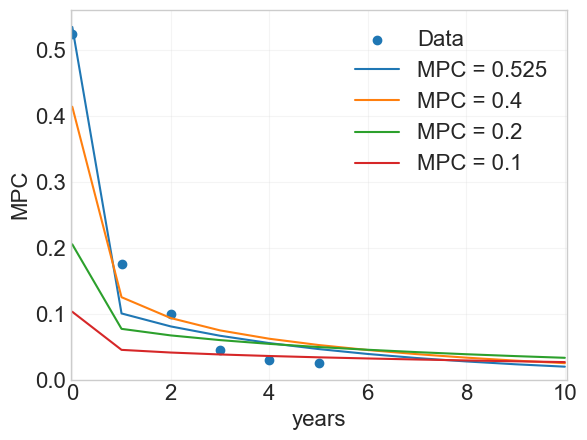

In [51]:
MPCs_data = [0.525, 0.175, 0.10, 0.045, 0.03, 0.025]
label_list = []
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(np.arange(6), MPCs_data, label='Data')
for m in model_list:
    MPCs_model = [m.jac_hh[('C_hh', 'ey')][0, (t * 4):(t * 4) + 4].sum() for t in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
    label = 'MPC = '+str(m.par.MPC_target)
    label_list.append(label)
    ax.plot(np.arange(11), MPCs_model, label=label)
ax.set_ylabel("MPC")
ax.set_xlabel('years')
ax.legend()
plt.xlim(xmin=-0.02, xmax=10.05)
plt.ylim(ymin=0.0)

(0.0, 0.7998178746382718)

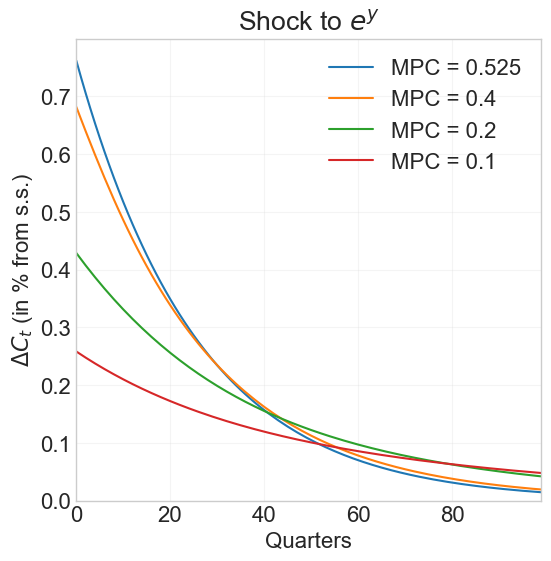

In [52]:
compare_inputs = ['ey']
compare_outputs = ['C_hh']
shocks_jump = [0.01 * m.ss.y for m in model_list]
shocks_rho = [0.95 for m in model_list]
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6 * 1, 6 * 1), dpi=100)
model_list = [model, model_04, model_02, model_01]
fig = plotter_PE(fig, model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, title_list=['$e^y$' for _ in range(len(model_list))])
plt.xlim(xmin=0.0,xmax=99.0)
plt.ylim(ymin=0.0)

(0.0, 0.555995068184242)

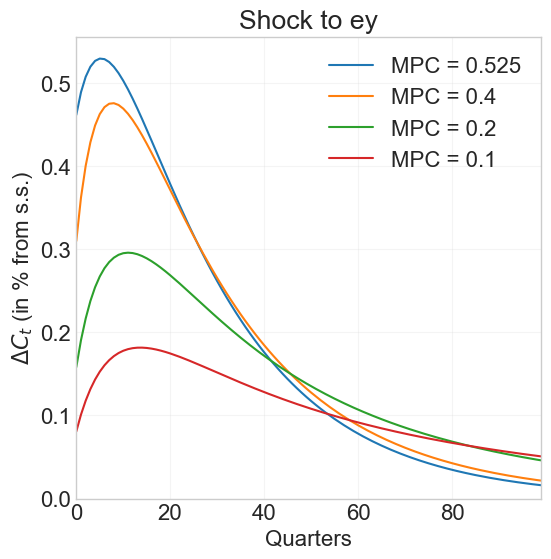

In [53]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6 * 1, 6 * 1), dpi=100)
fig = plotter_PE(fig, model_list_sticky, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)
plt.xlim(xmin=0.0,xmax=99.0)
plt.ylim(ymin=0.0)

NameError: name 'i_s' is not defined

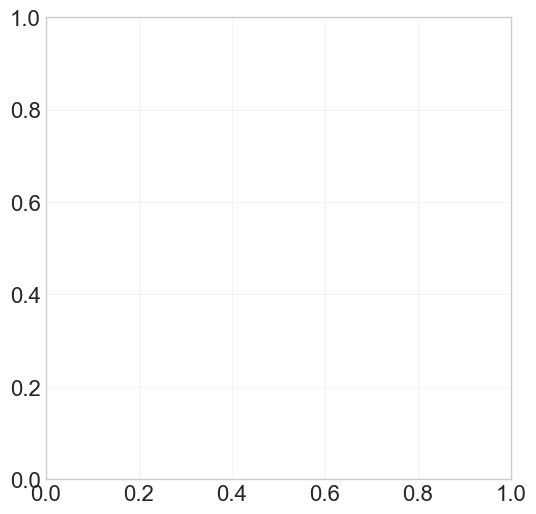

In [54]:
max_T = 100
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6 * 1, 6 * 1), dpi=100)
for i_m, m in enumerate(model_list):
    ss_value = m.ss.__dict__['y']
    shock_series =  0.01*ss_value*0.95**np.arange(m.par.T)

    jac = m.jac_hh[('C_hh', 'ey')].copy()
    IRF_abs_no_sticky = jac @ shock_series
    # IRF_perc_no_sticky = (IRF_abs_no_sticky / ss_value) * 100

    jac = model_list_sticky[i_m].jac_hh[('C_hh', 'ey')].copy()
    IRF_abs_sticky = jac @ shock_series
    # IRF_perc_sticky = (IRF_abs_sticky / ss_value) * 100

    IRF_perc = (IRF_abs_sticky - IRF_abs_no_sticky) / (IRF_abs_no_sticky + ss_value) * 100

    ax.plot(np.arange(max_T), IRF_perc[:max_T], label=label_list[i_s], linestyle='-')

ax.legend()
ax.set_ylabel('($C_t^{\\theta=0.935}$ - $C_t^{\\theta=0.0}$) / $C_t^{\\theta=0.0}$')
ax.set_xlabel('t')
plt.xlim(xmin=0.0, xmax=max_T-1)
# plt.ylim(ymin=0.0)

In [ ]:
plot_jacs(model_01, s_list=s_list, max_T=20, inputs_outputs=plot_list, inattention=0.935)

In [ ]:
plot_jacs(model_04, s_list=s_list, max_T=20, inputs_outputs=plot_list, inattention=0.935)

In [ ]:
(model_04_sticky.jac_hh[('C_hh', 'ey')][:5,:10] - model_04.jac_hh[('C_hh', 'ey')][:5,:10]) / model_04.jac_hh[('C_hh', 'ey')][:5,:10] * 100

In [ ]:
(model_01_sticky.jac_hh[('C_hh', 'ey')][:5,:10] - model_01.jac_hh[('C_hh', 'ey')][:5,:10]) / model_01.jac_hh[('C_hh', 'ey')][:5,:10] * 100

### Same for rl

In [ ]:
compare_inputs = ['rl']
compare_outputs = ['C_hh']
shocks_jump = [0.01 * m.ss.y for m in model_list]
shocks_rho = [0.95 for m in model_list]
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6 * 1, 6 * 1), dpi=100)
model_list = [model, model_04, model_02, model_01]
fig = plotter_PE(fig, model_list, label_list, compare_outputs, compare_inputs, max_T, shocks_jump, shocks_rho)
plt.xlim(xmin=0.0,xmax=100)
# plt.ylim(ymin=0.0)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6 * 1, 6 * 1), dpi=100)
fig = plotter_PE(fig, model_list_sticky, label_list, compare_outputs, compare_inputs, max_T, shocks_jump, shocks_rho)
plt.xlim(xmin=0.0,xmax=100)
# plt.ylim(ymin=0.0)

In [ ]:
max_T = 100
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6 * 1, 6 * 1), dpi=100)
for i_m, m in enumerate(model_list):
    ss_value = m.ss.__dict__['y']
    shock_series =  0.01*ss_value*0.95**np.arange(m.par.T)

    jac = m.jac_hh[('C_hh', 'ey')].copy()
    IRF_abs_no_sticky = jac @ shock_series
    # IRF_perc_no_sticky = (IRF_abs_no_sticky / ss_value) * 100

    jac = model_list_sticky[i_m].jac_hh[('C_hh', 'ey')].copy()
    IRF_abs_sticky = jac @ shock_series
    # IRF_perc_sticky = (IRF_abs_sticky / ss_value) * 100

    IRF_perc = (IRF_abs_sticky - IRF_abs_no_sticky) / (IRF_abs_no_sticky + ss_value) * 100

    ax.plot(np.arange(max_T), IRF_perc[:max_T], label=label_list[i_m], linestyle='-')

ax.legend()
ax.set_ylabel('($C_t^{\\theta=0.935}$ - $C_t^{\\theta=0.0}$) / $C_t^{\\theta=0.0}$')
ax.set_xlabel('t')
plt.xlim(xmin=0.0, xmax=max_T)
# plt.ylim(ymin=0.0)

## Changes in simga_e

In [14]:
model_low_sigma_e = HAsimpleModel.HAsimpleModelClass(par={'sigma_e': 0.25})
model_low_sigma_e.find_ss()
model_low_sigma_e._compute_jac_hh()
print(f'beta: {model_low_sigma_e.par.beta_mean}')
print(f'annualized beta: {model_low_sigma_e.par.beta_mean**4}')

beta: 0.9990574705721248
annualized beta: 0.9962352091103945


In [15]:
print(f'persistence: {model.par.rho_e}')
print(f'annual: {model.par.rho_e ** 4}')

persistence: 0.966
annual: 0.8707801203359999


In [16]:
# annual to quartlery formula
sigma_a = 0.92
rho_q = 0.91 ** (1/4)
sigma_a / (1 + rho_q ** 2 + rho_q ** 4 + rho_q ** 6)

0.24651503604659686

In [17]:
sigma_a = 0.6
rho_q = 0.966
sigma_a / (1 + rho_q ** 2 + rho_q ** 4 + rho_q ** 6)

0.1659058127330877

In [18]:
sigma1 = model_low_sigma_e.par.sigma_e
print(f'sigma: {sigma1}')


z_grid1, z_trans1, e_ergodic1, _, _ = log_rouwenhorst(par.rho_e, sigma1, n=par.Nz)
Dz1 = e_ergodic1
print(f'z_grid1: \n {z_grid1}')

sigma2 = model.par.sigma_e
print(f'sigma: {sigma2}')

z_grid2, z_trans2, e_ergodic2, _, _ = log_rouwenhorst(par.rho_e, sigma2, n=par.Nz)
Dz2 = e_ergodic2
print(f'z_grid2: \n {z_grid2}')

# print(f'sigma: {sigma1}')
# for z,pr_z in zip(z_grid1,Dz1/np.sum(Dz1)):
#     print(f' Pr[z = {z:.4f}] = {pr_z:.4f}')
# print(f'sigma: {sigma2}')
# for z,pr_z in zip(z_grid2,Dz2/np.sum(Dz2)):
#     print(f' Pr[z = {z:.4f}] = {pr_z:.4f}')

# print(f'sigma: {sigma1}')
# tab = np.concatenate((z_trans1, z_trans1.sum(axis=1).reshape(-1,1)), axis=1).round(3)
# index = np.array([f's = {s}' for s in range(par.Nz)]).reshape(-1,1)
# print(tab.shape, index.shape)
# tab = np.concatenate((index, tab), axis=1)
# header = [""] + [f's+ = {s}' for s in range(par.Nz)] + ["sum"]
# table = tabulate(tab, tablefmt='simple', headers=header)
# print(table)
# print(f'sigma: {sigma2}')
# tab = np.concatenate((z_trans2, z_trans2.sum(axis=1).reshape(-1,1)), axis=1).round(3)
# index = np.array([f's = {s}' for s in range(par.Nz)]).reshape(-1,1)
# print(tab.shape, index.shape)
# tab = np.concatenate((index, tab), axis=1)
# header = [""] + [f's+ = {s}' for s in range(par.Nz)] + ["sum"]
# table = tabulate(tab, tablefmt='simple', headers=header)
# print(table)

sigma: 0.25
z_grid1: 
 [0.05934389 0.13069537 0.28783554 0.63391148 1.39608809 3.07465947
 6.77144295]
sigma: 0.36
z_grid2: 
 [ 0.01314075  0.04096126  0.12768108  0.39799701  1.24060365  3.86710804
 12.05423228]


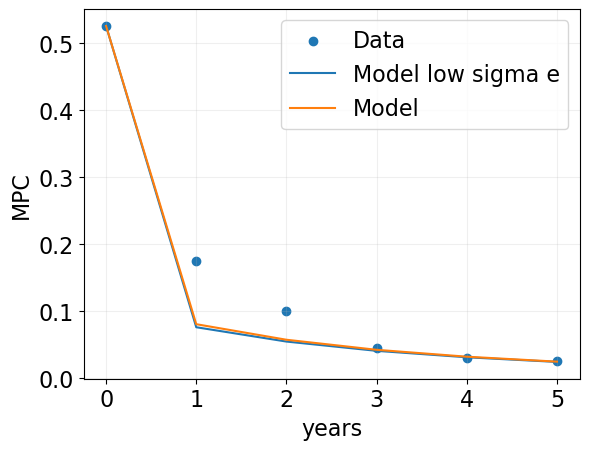

In [19]:
MPCs_data = [0.525, 0.175, 0.10, 0.045, 0.03, 0.025]

MPCs_model_ey = [
    np.sum([model.jac_hh[('C_hh', 'ey')][(t * 4 + i), 0] / (1 + ss.r) ** (t * 4 + i) for i in range(4)])
    for t in [0, 1, 2, 3, 4, 5]
]

MPCs_model_low_sigma_e_ey = [
    np.sum([model_low_sigma_e.jac_hh[('C_hh', 'ey')][(t * 4 + i), 0] / (1 + ss.r) ** (t * 4 + i) for i in range(4)])
    for t in [0, 1, 2, 3, 4, 5]
]

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(np.arange(6), MPCs_data, label='Data')
ax.plot(np.arange(6), MPCs_model_low_sigma_e_ey, label='Model low sigma e')
ax.plot(np.arange(6), MPCs_model_ey, label='Model')
ax.set_ylabel("MPC")
ax.set_xlabel('years')
ax.legend()

(-0.05, 5.1)

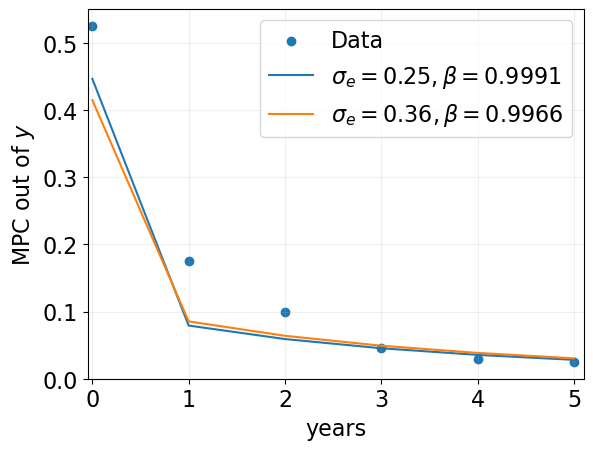

In [33]:
MPCs_data = [0.525, 0.175, 0.10, 0.045, 0.03, 0.025]

MPCs_model_y = [
    np.sum([model.jac_hh[('C_hh', 'y')][(t * 4 + i), 0] / (1 + ss.r) ** (t * 4 + i) for i in range(4)])
    for t in [0, 1, 2, 3, 4, 5]
]

MPCs_model_low_sigma_e_y = [
    np.sum([model_low_sigma_e.jac_hh[('C_hh', 'y')][(t * 4 + i), 0] / (1 + ss.r) ** (t * 4 + i) for i in range(4)])
    for t in [0, 1, 2, 3, 4, 5]
]

model_list = [model, model_low_sigma_e]
label_list = [f'$\\sigma_e = {model_list[0].par.sigma_e}, \\beta = {model_list[0].par.beta_mean:.4f}$',
              f'$\\sigma_e = {model_list[1].par.sigma_e}, \\beta = {model_list[1].par.beta_mean:.4f}$']


fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(np.arange(6), MPCs_data, label='Data')
ax.plot(np.arange(6), MPCs_model_low_sigma_e_y, label=label_list[1])
ax.plot(np.arange(6), MPCs_model_y, label=label_list[0])
ax.set_ylabel("MPC out of $y$")
ax.set_xlabel('years')
ax.legend()
ax.set_xlim([-0.05,5.1])

Text(0, 0.5, 'consumption, $c_t$')

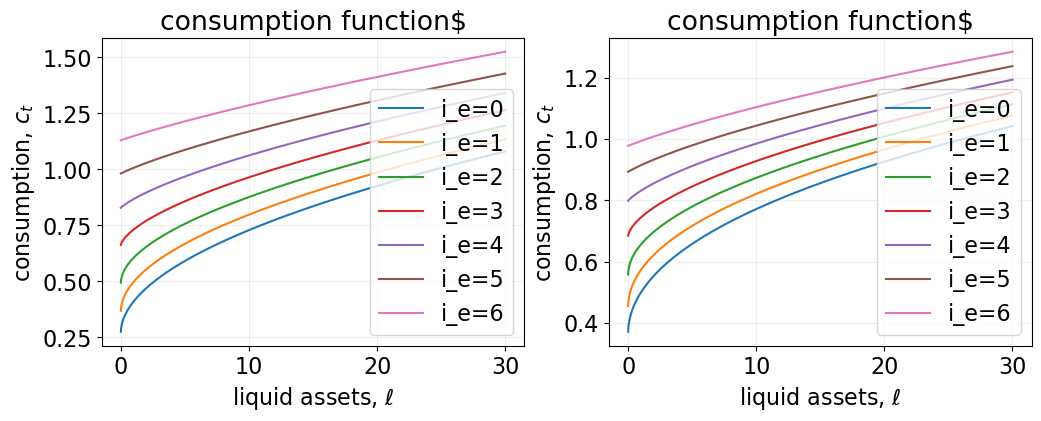

In [21]:

fig = plt.figure(figsize=(12,4),dpi=100)

c = model.ss.c[0, :, :]
l = model.ss.l[0, :, :]

ax = fig.add_subplot(1,2,1)
ax.set_title(f'consumption function$')
for i_e in range(par.Nz):
    ax.plot(par.l_grid, c[i_e,:], label=f'i_e={i_e}')
ax.legend(frameon=True)
ax.set_xlabel('liquid assets, $\ell$')
ax.set_ylabel('consumption, $c_t$')



ax = fig.add_subplot(1,2,2)
c = model_low_sigma_e.ss.c[0, :, :]
l = model_low_sigma_e.ss.l[0, :, :]

ax.set_title(f'consumption function$')
for i_e in range(par.Nz):
    ax.plot(par.l_grid, c[i_e,:], label=f'i_e={i_e}')
ax.legend(frameon=True)
ax.set_xlabel('liquid assets, $\ell$')
ax.set_ylabel('consumption, $c_t$')

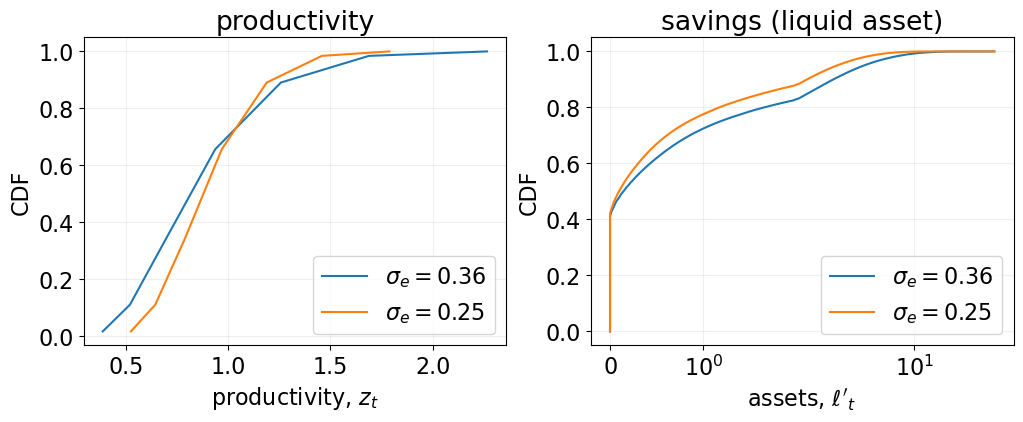

In [22]:
fig = plt.figure(figsize=(12,4),dpi=100)

ss = model.ss
par = model.par

# a. income
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('productivity')
ax1.plot(par.z_grid,np.cumsum(np.sum(ss.D,axis=(0,2))), label = f'$\sigma_e = {par.sigma_e}$')

ax1.set_xlabel('productivity, $z_{t}$')
ax1.set_ylabel('CDF')

# b. liquid assets
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('savings (liquid asset)')
ax2.plot(np.insert(par.l_grid,0,par.l_grid[0]),np.insert(np.cumsum(np.sum(ss.D,axis=(0,1))),0,0.0),label=f'$\sigma_e = {par.sigma_e}$')
ax2.set_xlabel('assets, $\ell\'_{t}$')
ax2.set_ylabel('CDF')
ax2.set_xscale('symlog')

ss = model_low_sigma_e.ss
par = model_low_sigma_e.par
# a. income
ax1.plot(par.z_grid,np.cumsum(np.sum(ss.D,axis=(0,2))), label=f'$\sigma_e = {par.sigma_e}$')
ax1.legend()
# b. liquid assets
ax2.plot(np.insert(par.l_grid,0,par.l_grid[0]),np.insert(np.cumsum(np.sum(ss.D,axis=(0,1))),0,0.0),label=f'$\sigma_e = {par.sigma_e}$')
ax2.legend()



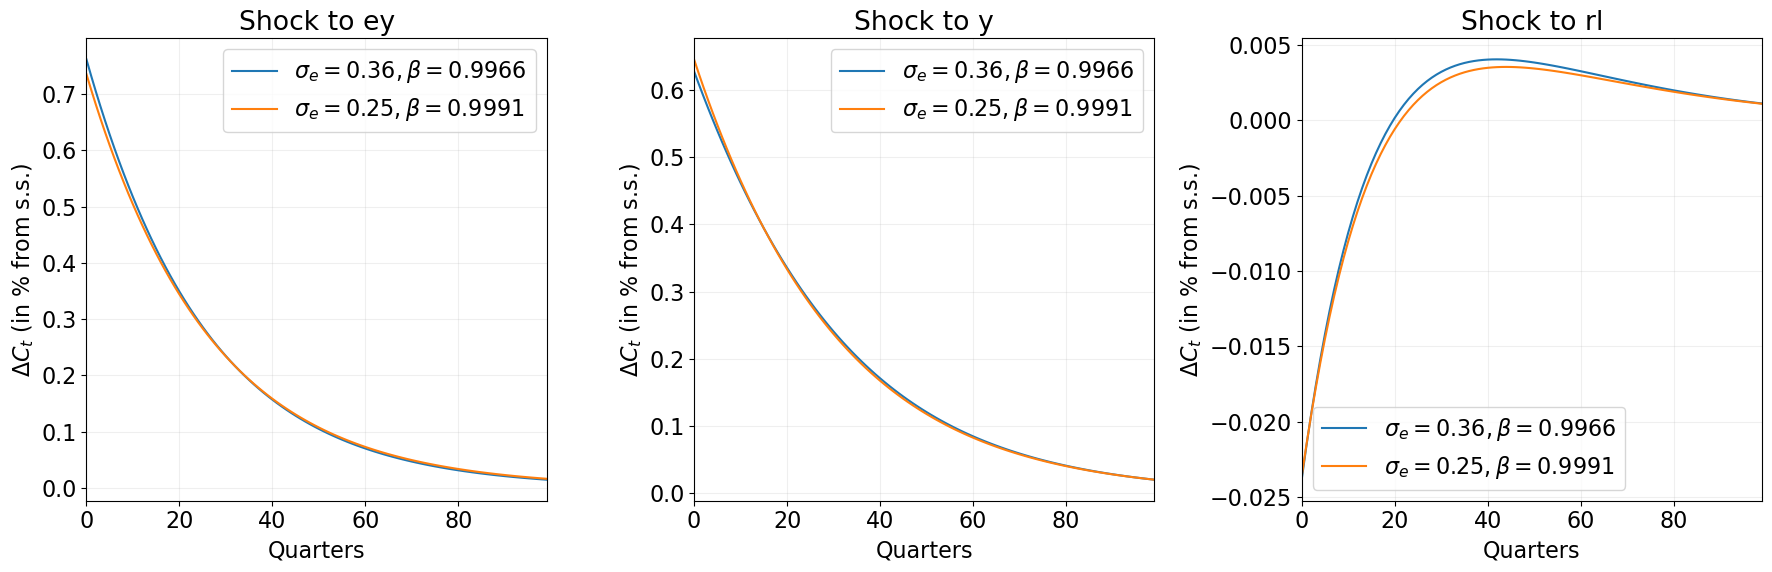

In [28]:
model_list = [model, model_low_sigma_e]
label_list = [f'$\\sigma_e = {model_list[0].par.sigma_e}, \\beta = {model_list[0].par.beta_mean:.4f}$',
              f'$\\sigma_e = {model_list[1].par.sigma_e}, \\beta = {model_list[1].par.beta_mean:.4f}$']

compare_outputs = ['C_hh']
compare_inputs = ['ey', 'y', 'rl']

plot_periods = 100  # model.par.T

# 1 % jump in income
ss = model.ss

shocks_jump = [0.01 * ss.y, 0.01 * ss.y, 0.01 * abs(ss.rl)]
shocks_rho = [0.95, 0.95, 0.95]
# shocks_jump = [0.01 * (1 - ss.tau) * ss.wN, -0.01 * ss.tau, 0.01*ss.wN, 0.01 * abs(ss.rl), 0.01 * ss.ra]
# shocks_rho =[0.966, 0.966, 0.966, 0.966, 0.966]

fig = plot_PE_hh(model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)
# fig = plotter_PE(fig, [model], ['no intertemp'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, decompose=True)
fig.tight_layout()

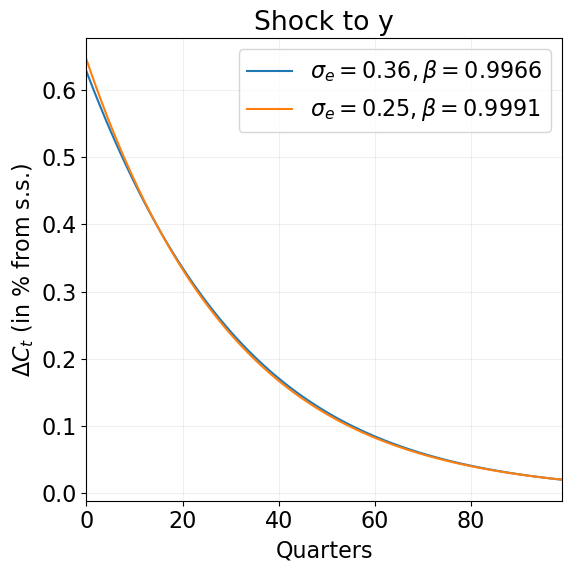

In [34]:
model_list = [model, model_low_sigma_e]
label_list = [f'$\\sigma_e = {model_list[0].par.sigma_e}, \\beta = {model_list[0].par.beta_mean:.4f}$',
              f'$\\sigma_e = {model_list[1].par.sigma_e}, \\beta = {model_list[1].par.beta_mean:.4f}$']

compare_outputs = ['C_hh']
compare_inputs = ['y']

plot_periods = 100  # model.par.T

# 1 % jump in income
ss = model.ss

shocks_jump = [0.01 * ss.y]
shocks_rho = [0.95]
# shocks_jump = [0.01 * (1 - ss.tau) * ss.wN, -0.01 * ss.tau, 0.01*ss.wN, 0.01 * abs(ss.rl), 0.01 * ss.ra]
# shocks_rho =[0.966, 0.966, 0.966, 0.966, 0.966]

fig = plot_PE_hh(model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)
# fig = plotter_PE(fig, [model], ['no intertemp'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, decompose=True)
fig.tight_layout()